In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP
from scipy.stats import kurtosis as kurt
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
# Read data
df_health=pd.read_csv('health.csv')
df_titanic=pd.read_csv('titanic_train.csv')
df_titanic_t=pd.read_csv('titanic_test.csv')

df_titanic.drop('Cabin', axis=1, inplace=True)
df_titanic_t.drop('Cabin', axis=1, inplace=True)
df_titanic.loc[df_titanic['Sex'] == 'male', 'gender'] = int(0)
df_titanic.loc[df_titanic['Sex'] == 'female', 'gender'] = int(1)
df_titanic_t.loc[df_titanic_t['Sex'] == 'male', 'gender'] = int(0)
df_titanic_t.loc[df_titanic_t['Sex'] == 'female', 'gender'] = int(1)
df_titanic.loc[df_titanic['Embarked'] == 'S', 'embarked_n'] = int(0)
df_titanic.loc[df_titanic['Embarked'] == 'C', 'embarked_n'] = int(1)
df_titanic.loc[df_titanic['Embarked'] == 'Q', 'embarked_n'] = int(2)
df_titanic_t.loc[df_titanic_t['Embarked'] == 'S', 'embarked_n'] = int(0)
df_titanic_t.loc[df_titanic_t['Embarked'] == 'C', 'embarked_n'] = int(1)
df_titanic_t.loc[df_titanic_t['Embarked'] == 'Q', 'embarked_n'] = int(2)

df_health_dn=df_health.dropna().reset_index(drop=True)
df_titanic_dn=df_titanic.dropna().reset_index(drop=True)
df_titanic_t_dn=df_titanic_t.dropna().reset_index(drop=True)
df_titanic_f=pd.concat([df_titanic_dn, df_titanic_t_dn], ignore_index=True)

In [35]:
df_health_dn.head()

group      ID  outcome  age  ...  Bicarbonate  Lactic acid       PCO2  EF
0      1  125047      0.0   72  ...    21.166667        0.500  40.000000  55
1      1  109787      0.0   83  ...    30.571429        0.500  71.500000  35
2      1  130587      0.0   43  ...    38.571429        0.600  75.000000  55
3      1  154653      0.0   76  ...    30.500000        0.600  65.500000  35
4      1  194420      0.0   72  ...    26.800000        0.625  69.769231  55

[5 rows x 51 columns]

In [3]:
X_health=df_health_dn.drop('outcome', axis=1)
X_titanic=df_titanic_f.drop(['PassengerId','Survived', 'Name', 'Sex', 'Ticket','Embarked'], axis=1)

scaler_h=StandardScaler()
scaler_h.fit(X_health)
scaled_health=scaler_h.transform(X_health)

scaler_t=StandardScaler()
scaler_t.fit(X_titanic)
scaled_titanic=scaler_t.transform(X_titanic)

In [4]:
def plot_CFmatrix(confusion_matrix):
  fig=plt.figure(figsize=(5,4))
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='0.0f')
  plt.title('Confusion Matrix')
  plt.xlabel('Prediction')
  plt.ylabel('True Label')

In [105]:
df_health_dn

group      ID  outcome  age  ...  Bicarbonate  Lactic acid       PCO2  EF
0        1  125047      0.0   72  ...    21.166667        0.500  40.000000  55
1        1  109787      0.0   83  ...    30.571429        0.500  71.500000  35
2        1  130587      0.0   43  ...    38.571429        0.600  75.000000  55
3        1  154653      0.0   76  ...    30.500000        0.600  65.500000  35
4        1  194420      0.0   72  ...    26.800000        0.625  69.769231  55
..     ...     ...      ...  ...  ...          ...          ...        ...  ..
423      2  127201      0.0   83  ...    23.000000        3.550  48.333333  55
424      2  149303      0.0   37  ...    26.333333        3.775  29.000000  20
425      2  130745      0.0   61  ...    24.333333        4.150  43.000000  20
426      2  177737      0.0   71  ...    32.933333        4.160  42.870968  55
427      2  122715      0.0   37  ...    21.666667        4.200  21.000000  15

[428 rows x 51 columns]

In [7]:
df_titanic_f.head()

PassengerId  Survived  Pclass  ... Embarked gender  embarked_n
0            1         0       3  ...        S    0.0         0.0
1            2         1       1  ...        C    1.0         1.0
2            3         1       3  ...        S    1.0         0.0
3            4         1       1  ...        S    1.0         0.0
4            5         0       3  ...        S    0.0         0.0

[5 rows x 13 columns]

### Cluster

##### Kmeans

In [28]:
np.array(scores)[:,1]

array([0.1364688 , 0.07703882, 0.06251194, 0.18123793, 0.14010357,
       0.19998135, 0.24306486, 0.16955181, 0.10522415, 0.15911785,
       0.16821972, 0.20647667, 0.17832924])

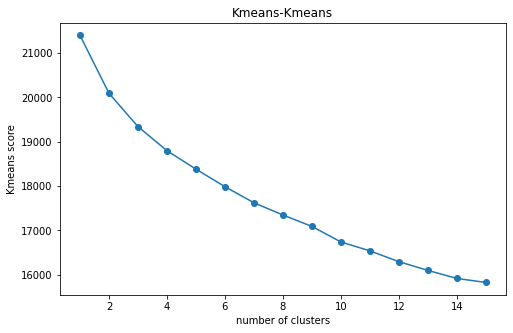

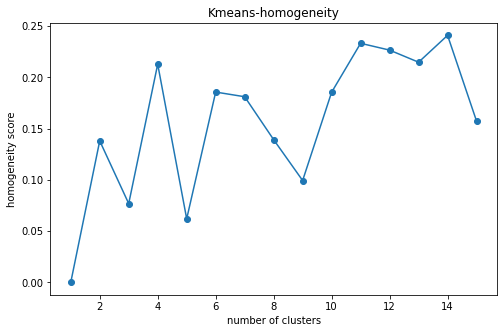

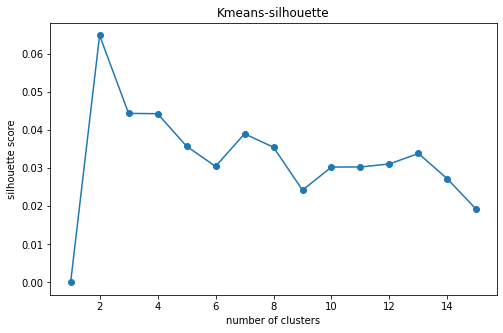

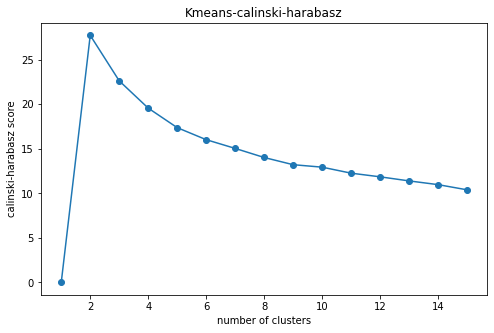

In [22]:
# health data
scores=[]
cluster_labels=[]

for i in range(2, 16):
  km=KMeans(n_clusters=i)
  km.fit(scaled_health)

  pred=km.predict(scaled_health)
  score=km.score(scaled_health)
  ho_score=homogeneity_score(df_health_dn['outcome'], pred)
  if i>1:
    si_score=silhouette_score(scaled_health, pred)
    ca_score=calinski_harabasz_score(scaled_health, pred)
  else:
    si_score=0
    ca_score=0

  scores.append([-score, ho_score, si_score, ca_score])
  cluster_labels.append(pred)

# plot
num_clusters=np.arange(2,16)
score_types=['Kmeans', 'homogeneity', 'silhouette', 'calinski-harabasz']
i=0

for score_type in score_types:
  fig= plt.figure(figsize=(8,5))
  plt.plot(num_clusters, np.array(scores)[:,i] , marker='o')
  plt.title('Kmeans-{}'.format(score_type))
  plt.xlabel('number of clusters')
  plt.ylabel('{} score'.format(score_type))
  i+=1

In [6]:
scores

[[20093.277467752232,
  0.1284057668705739,
  0.06136714844957609,
  27.703982072160148],
 [19342.54944478864,
  0.08391684373875063,
  0.041437563365630536,
  22.603444506132963],
 [18808.839033614087,
  0.20460868941180024,
  0.043952900673781735,
  19.470495543507948],
 [18393.75366923518,
  0.18044163455748707,
  0.030854214084378773,
  17.283614600651457],
 [18013.329192748562,
  0.11510132316005663,
  0.030273468328405495,
  15.867972714732097],
 [17642.594601567413,
  0.05299917501579748,
  0.04926514194884315,
  14.943641685216194],
 [17348.561269459544,
  0.14592688670712242,
  0.031633799602439706,
  14.011901047976654],
 [17007.113415141874,
  0.1618700103497998,
  0.03425594477578485,
  13.528306025001298],
 [16818.536222678867,
  0.14801334237189423,
  0.024010198896987398,
  12.651727657077485],
 [16480.022137951477,
  0.1296254796325706,
  0.018719759695451522,
  12.449199104833607],
 [16214.151348985291,
  0.1881001298984282,
  0.02854503599054603,
  12.095567812614538]

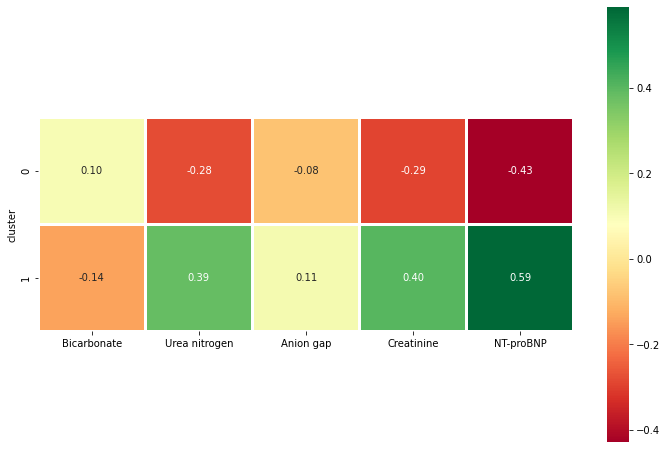

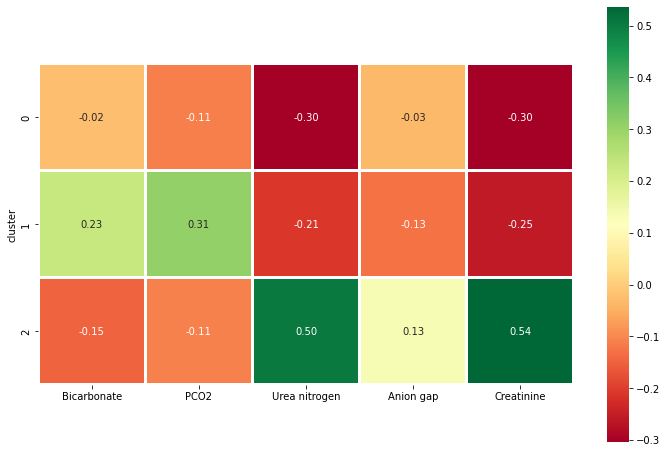

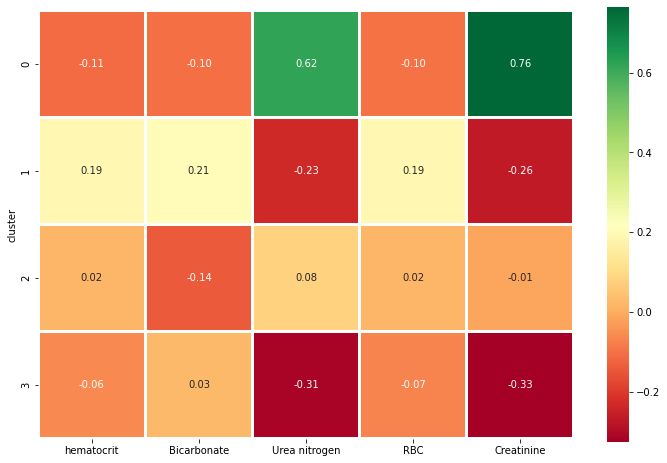

In [16]:
health_avg = df_health_dn.drop(['outcome', 'ID'], axis=1).mean()

for i in range (1,4):
  health_scaled_kn=pd.DataFrame(scaled_health, columns=X_health.columns).drop(['ID'], axis=1)
  health_kn=df_health_dn.drop(['outcome', 'ID'], axis=1)
  n=i-1
  health_kn['cluster']=cluster_labels[n]
  health_scaled_kn['cluster']=cluster_labels[n]
  scaled_avg=health_scaled_kn.groupby(['cluster']).mean()
  cluster_avg = health_kn.groupby(['cluster']).mean()
  relative_imp = cluster_avg / health_avg - 1
  #print(cluster_avg)
  #print(health_avg)
  #print(relative_imp)

  features={}
  for column in scaled_avg.columns:
    features[column]=np.var(scaled_avg[column])
  selected_columns=sorted(features, key=features.get, reverse=True)[:5]
  #print(selected_columns)

  fig=plt.figure(figsize=(12,8))
  sns.heatmap(data=relative_imp[selected_columns],annot=True,fmt='.2f',
              cmap='RdYlGn',linewidths=2,square=True)

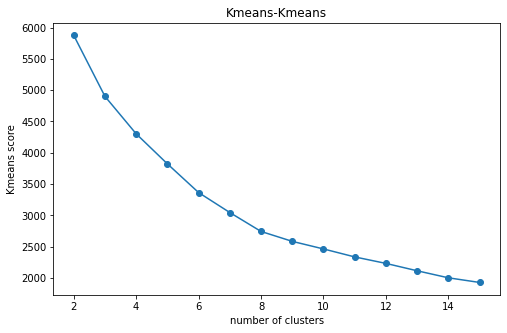

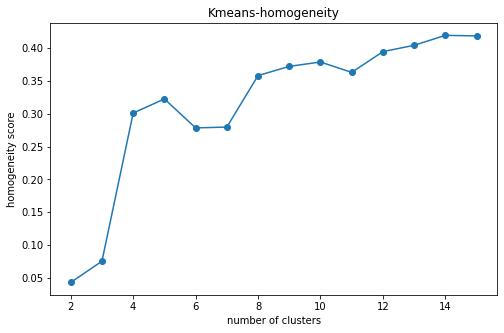

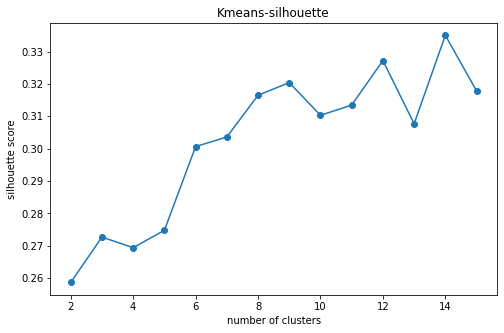

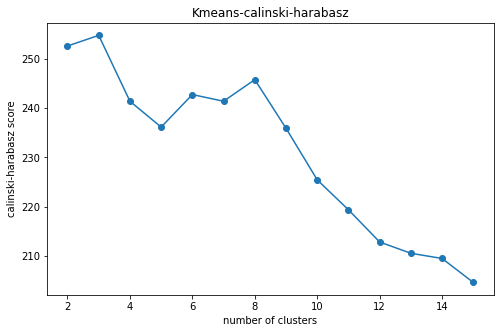

In [17]:
# titanic data
scores_t=[]
cluster_labels_t=[]

for i in range(2, 16):
  km=KMeans(n_clusters=i)
  km.fit(scaled_titanic)

  pred=km.predict(scaled_titanic)
  score=km.score(scaled_titanic)
  ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
  si_score=silhouette_score(scaled_titanic, pred)
  ca_score=calinski_harabasz_score(scaled_titanic, pred)
  scores_t.append([-score, ho_score, si_score, ca_score])
  cluster_labels_t.append(pred)

# plot
num_clusters=np.arange(2,16)
score_types=['Kmeans', 'homogeneity', 'silhouette', 'calinski-harabasz']
i=0

for score_type in score_types:
  fig= plt.figure(figsize=(8,5))
  plt.plot(num_clusters, np.array(scores_t)[:,i] , marker='o')
  plt.title('Kmeans-{}'.format(score_type))
  plt.xlabel('number of clusters')
  plt.ylabel('{} score'.format(score_type))
  i+=1

In [9]:
scores_t

[[5875.452517958553,
  0.04283575103995962,
  0.25866740502746616,
  252.57542704485655],
 [4900.407126520211,
  0.07527607918267971,
  0.27267622951918574,
  254.7356295059345],
 [4307.537818172385,
  0.2895627348063844,
  0.2665084889666693,
  240.6794274134783],
 [3806.1392832875154,
  0.3027609952963632,
  0.2818014200456408,
  238.27723803201206],
 [3363.219125335863,
  0.27040556757592815,
  0.2990606563122581,
  242.83156195592358],
 [3016.709241624875,
  0.24504706790123407,
  0.305520885560876,
  245.2189273239302],
 [2742.356425780313,
  0.3446587621222099,
  0.3152215530745435,
  245.78424884956658],
 [2611.5193076648266,
  0.3904207135246646,
  0.3261681764757892,
  232.09301103207184],
 [2428.202594552665,
  0.3907221608105171,
  0.3121493024005103,
  230.3303929471343],
 [2341.945463477301,
  0.3908641298134421,
  0.29917239678918195,
  218.52533978706072],
 [2219.0254687482998,
  0.3862610983277006,
  0.32075435659692175,
  214.65261196500043],
 [2087.9775822558604,
  0.

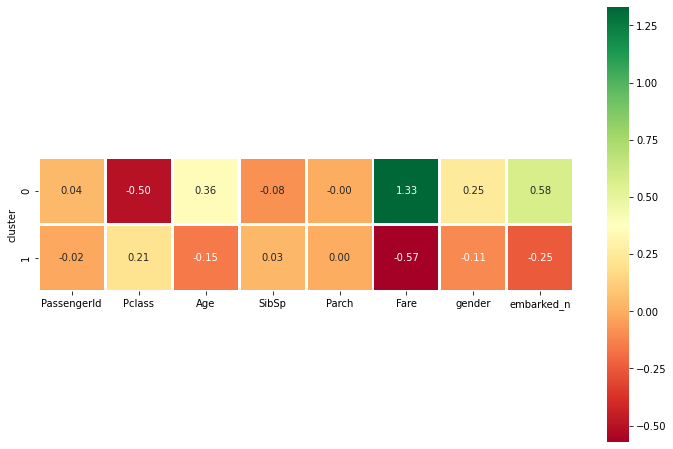

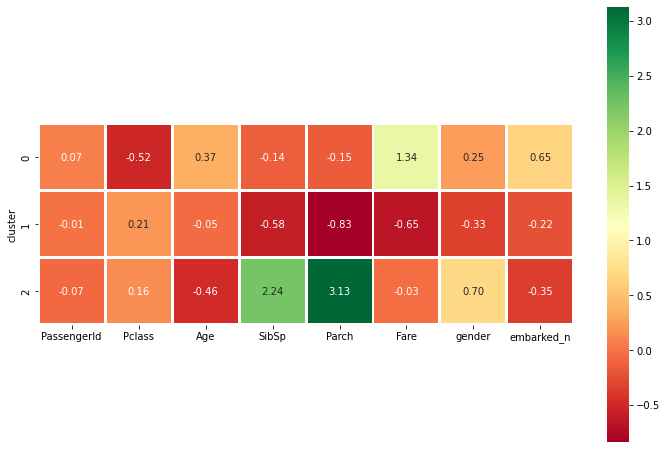

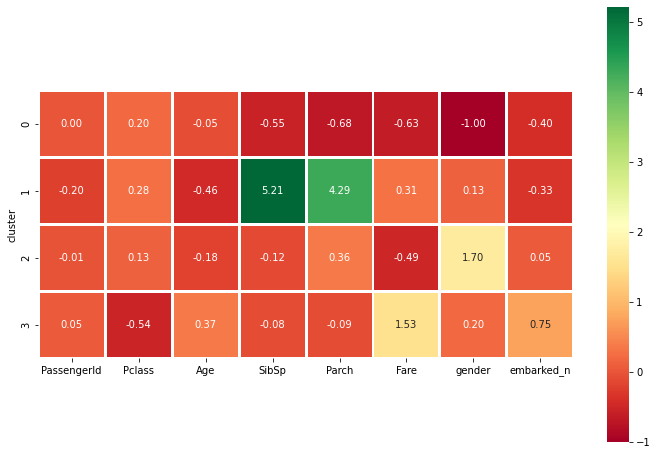

In [19]:
titanic_avg = df_titanic_f.drop('Survived', axis=1).mean()

for i in range (1,4):
  titanic_kn=df_titanic_f.drop('Survived', axis=1)
  n=i-1
  titanic_kn['cluster']=cluster_labels_t[n]
  #titanic_kn = titanic_kn.assign(cluster = cluster_labels[n])
  cluster_avg = titanic_kn.groupby(['cluster']).mean()
  relative_imp = cluster_avg / titanic_avg - 1
  #print(relative_imp)
  fig=plt.figure(figsize=(12,8))
  sns.heatmap(data=relative_imp,annot=True,fmt='.2f',
              cmap='RdYlGn',linewidths=2,square=True)


#### EM

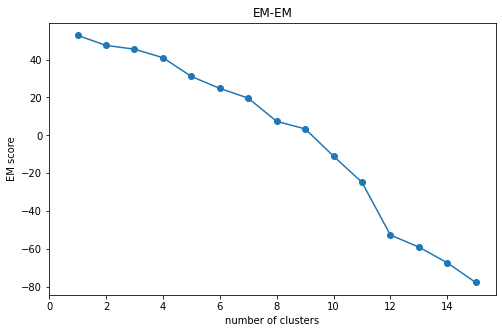

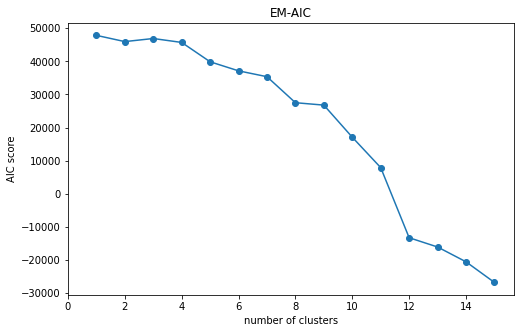

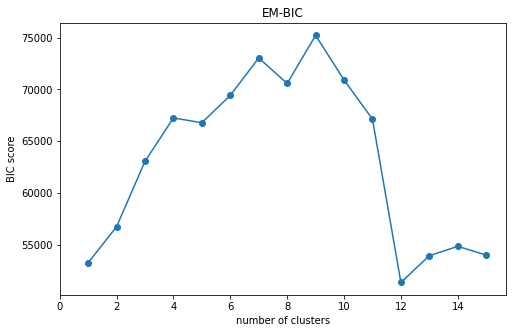

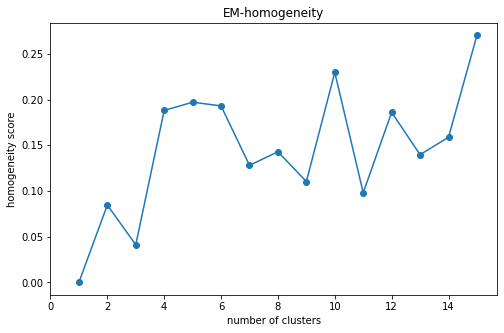

In [10]:
# health data
scores=[]
cluster_labels=[]

for i in range(1, 16):
  gm=GaussianMixture(n_components=i)
  gm.fit(scaled_health)

  pred=gm.predict(scaled_health)
  score=gm.score(scaled_health)
  aic=gm.aic(scaled_health)
  bic=gm.bic(scaled_health)
  ho_score=homogeneity_score(df_health_dn['outcome'], pred)
  #si_score=silhouette_score(scaled_health, pred)
  #ca_score=calinski_harabasz_score(scaled_health, pred)
  scores.append([-score, aic, bic, ho_score])
  cluster_labels.append(pred)

# plot
num_clusters=np.arange(1,16)
score_types=['EM', 'AIC', 'BIC','homogeneity']
i=0

for score_type in score_types:
  fig= plt.figure(figsize=(8,5))
  plt.plot(num_clusters, np.array(scores)[:,i] , marker='o')
  plt.title('EM-{}'.format(score_type))
  plt.xlabel('number of clusters')
  plt.ylabel('{} score'.format(score_type))
  plt.xlim(left=0)
  i+=1

In [11]:
scores

[[52.81000163968466,
  47855.36140357007,
  53233.699637715945,
  -1.7594135943790813e-15],
 [47.5075722059431,
  45968.481808287295,
  56729.217399774636,
  0.0847159918807212],
 [45.49991530837117,
  46901.92750396572,
  63045.060452794525,
  0.041204518349350794],
 [41.01691742896705,
  45716.481319195795,
  67242.01162536607,
  0.18806160707534272],
 [31.094272359312402,
  39874.69713957142,
  66782.62480308315,
  0.19710052893736474],
 [24.799774547885395, 37138.6070129899, 69428.93203384308, 0.1930615184870882],
 [19.636255506945734,
  35370.63471394555,
  73043.3570921402,
  0.12804198006393264],
 [7.366731730679212,
  27519.922361461406,
  70575.04209699752,
  0.1429069560341994],
 [3.4186582785946107,
  26792.371486476986,
  75229.88857935456,
  0.11037241437699079],
 [-10.998858831428466,
  17102.976840297233,
  70922.89129051627,
  0.2296647095463549],
 [-24.822537165509647,
  7921.908186323741,
  67124.21999388424,
  0.09810850214113438],
 [-52.65333237960402,
  -13249.2525

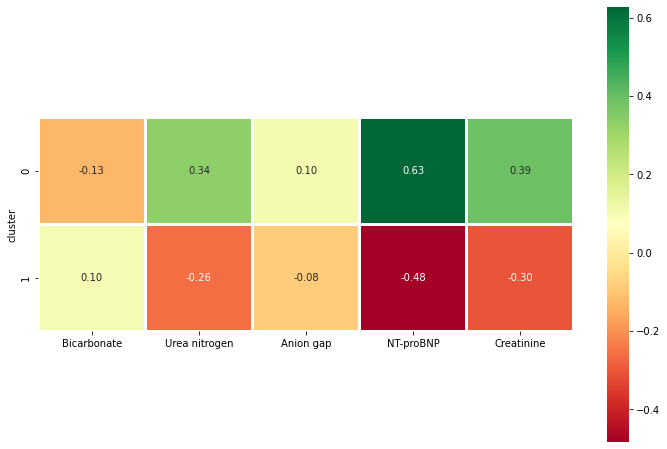

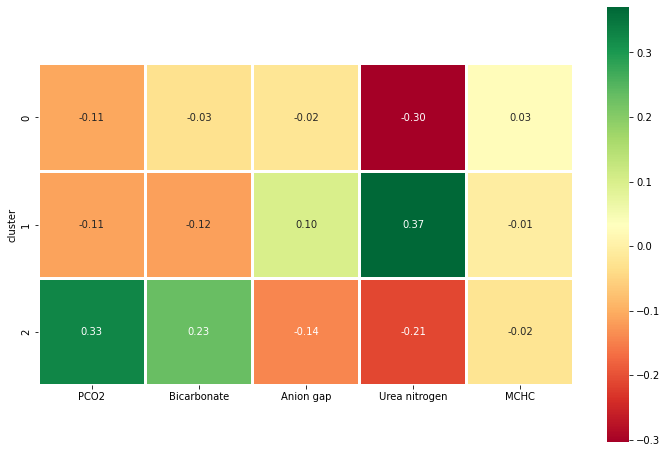

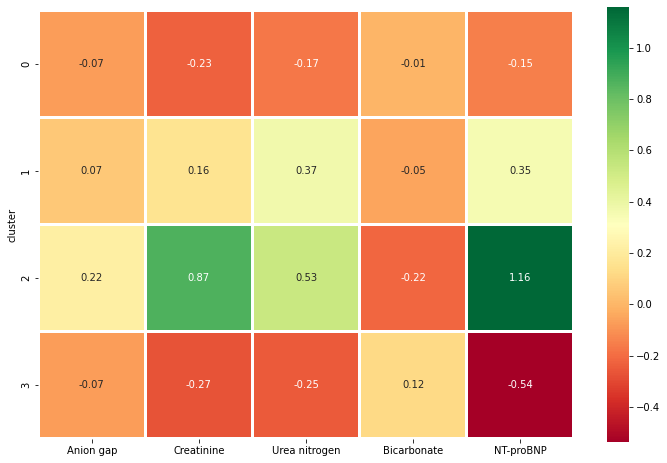

In [30]:
# feature importance plot
health_avg = df_health_dn.drop(['outcome', 'ID'], axis=1).mean()

for i in range (2,5):
  health_scaled_kn=pd.DataFrame(scaled_health, columns=X_health.columns).drop(['ID'], axis=1)
  health_kn=df_health_dn.drop(['outcome', 'ID'], axis=1)
  n=i-1
  health_kn['cluster']=cluster_labels[n]
  health_scaled_kn['cluster']=cluster_labels[n]
  scaled_avg=health_scaled_kn.groupby(['cluster']).mean()
  cluster_avg = health_kn.groupby(['cluster']).mean()
  relative_imp = cluster_avg / health_avg - 1
  #print(cluster_avg)
  #print(health_avg)
  #print(relative_imp)

  features={}
  for column in scaled_avg.columns:
    features[column]=np.var(scaled_avg[column])
  selected_columns=sorted(features, key=features.get, reverse=True)[:5]
  #print(selected_columns)

  fig=plt.figure(figsize=(12,8))
  sns.heatmap(data=relative_imp[selected_columns],annot=True,fmt='.2f',
              cmap='RdYlGn',linewidths=2,square=True)


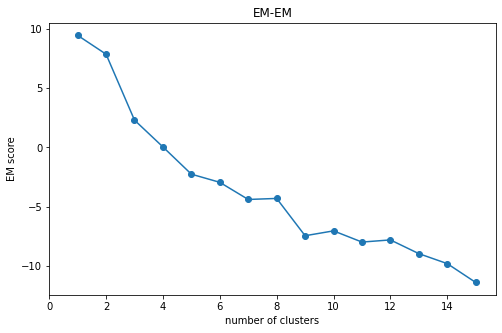

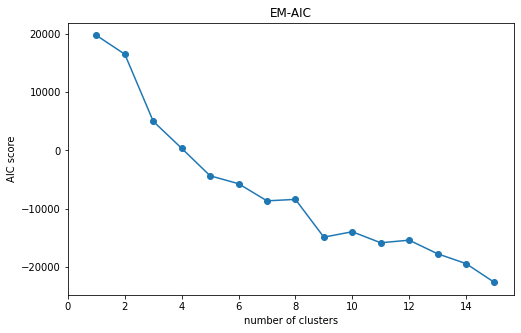

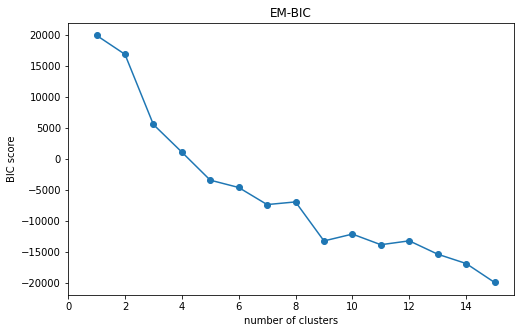

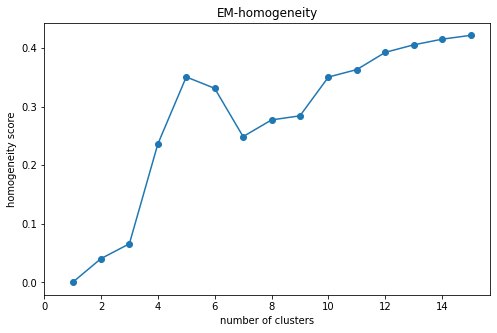

In [12]:
# titanic data
scores_t=[]
cluster_labels=[]

for i in range(1, 16):
  gm=GaussianMixture(n_components=i)
  gm.fit(scaled_titanic)

  pred=gm.predict(scaled_titanic)
  score=gm.score(scaled_titanic)
  aic=gm.aic(scaled_titanic)
  bic=gm.bic(scaled_titanic)
  ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
  #si_score=silhouette_score(scaled_titanic, pred)
  #ca_score=calinski_harabasz_score(scaled_titanic, pred)
  scores_t.append([-score, aic, bic, ho_score])
  cluster_labels.append(pred)

# plot
num_clusters=np.arange(1,16)
score_types=['EM', 'AIC','BIC','homogeneity']
i=0

for score_type in score_types:
  fig= plt.figure(figsize=(8,5))
  plt.plot(num_clusters, np.array(scores_t)[:,i] , marker='o')
  plt.title('EM-{}'.format(score_type))
  plt.xlabel('number of clusters')
  plt.ylabel('{} score'.format(score_type))
  plt.xlim(left=0)
  i+=1

In [13]:
scores_t

[[9.42541399930141,
  19731.413602542743,
  19904.65857846777,
  3.3035118368152807e-16],
 [7.839202755158439,
  16494.576947260502,
  16846.01675556556,
  0.040618701869911795],
 [2.291380584228998,
  4993.819898701689,
  5523.454539386772,
  0.06598961567195094],
 [0.03647179490980165,
  362.08016418184627,
  1069.9096372469567,
  0.23612983729709552],
 [-2.256304809800848,
  -4348.6518332445685,
  -3462.62752779943,
  0.35076902715840674],
 [-2.9434960085085997,
  -5710.132673748939,
  -4645.9135359237725,
  0.3313275081508519],
 [-4.38540716139974,
  -8645.959338679857,
  -7403.545368474663,
  0.24891912586127762],
 [-4.2990595109162815,
  -8393.838139771364,
  -6973.2293371861415,
  0.27739972776176647],
 [-7.437779236651459,
  -14869.207487654943,
  -13270.403852689693,
  0.2843967885396231],
 [-7.027831464684565,
  -13942.056435332004,
  -12165.057967986726,
  0.35061126195412573],
 [-7.970488656285031,
  -15836.439337010575,
  -13881.24603728527,
  0.3633174029950348],
 [-7.789

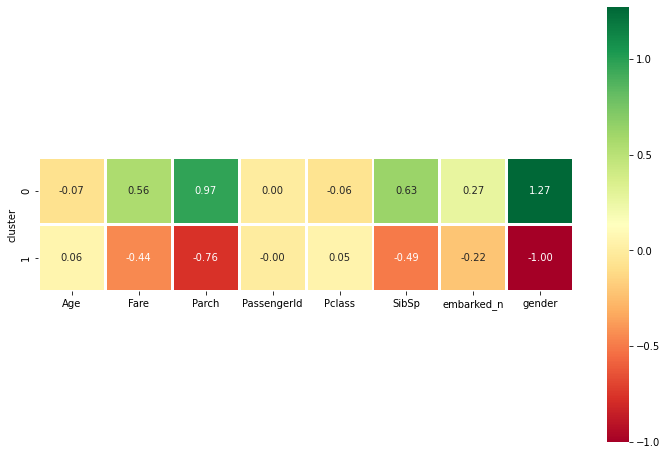

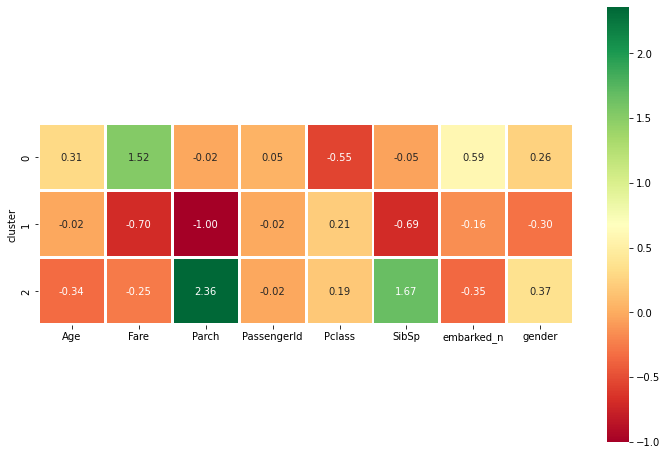

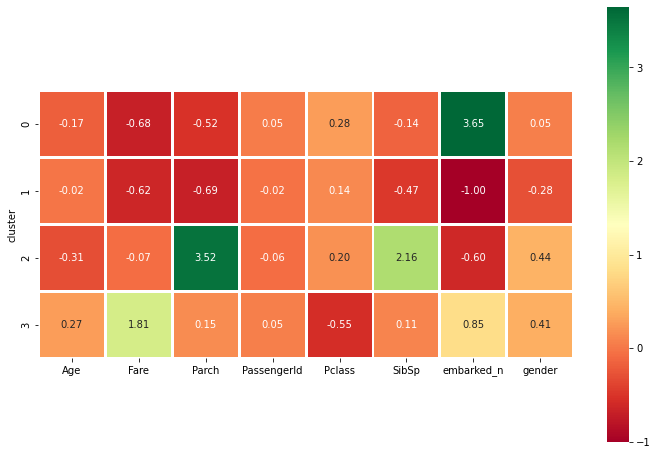

In [10]:
# feature importance plot
titanic_avg = df_titanic_f.drop('Survived', axis=1).mean()

for i in range (2,5):
  titanic_kn=df_titanic_f.drop('Survived', axis=1)
  n=i-1
  titanic_kn['cluster']=cluster_labels[n]
  #titanic_kn = titanic_kn.assign(cluster = cluster_labels[n])
  cluster_avg = titanic_kn.groupby(['cluster']).mean()
  relative_imp = cluster_avg / titanic_avg - 1
  #print(relative_imp)
  fig=plt.figure(figsize=(12,8))
  sns.heatmap(data=relative_imp.drop('cluster', axis=1),annot=True,fmt='.2f',
              cmap='RdYlGn',linewidths=2,square=True)



### reduced dimention + clustering

#### Health data

##### PCA

In [112]:
def column_names(i, name):
  columns=[name+str(x+1) for x in range(i)]
  return columns

Text(0.5, 0, 'number of components')

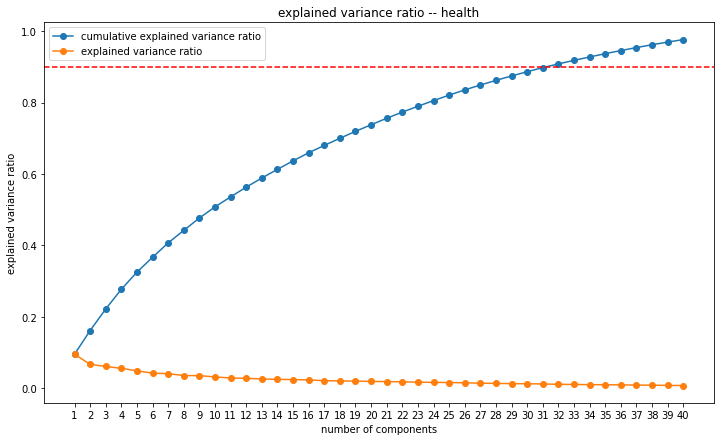

In [63]:
# PCA
pca=PCA(n_components=40, random_state=3)
pca.fit(scaled_health)

varr_cum=np.cumsum(pca.explained_variance_ratio_)

# plot explained variance ratio
fig=plt.figure(figsize=(12,7))
plt.plot(np.arange(1,41), varr_cum, marker='o', label='cumulative explained variance ratio')
plt.plot(np.arange(1,41), pca.explained_variance_ratio_, marker='o', 
         label='explained variance ratio')
plt.legend()
plt.xticks(np.arange(1,41))
plt.axhline(y=0.9, linestyle='--', color='r')
plt.title('explained variance ratio -- health')
plt.ylabel('explained variance ratio')
plt.xlabel('number of components')

Text(0.5, 0, 'number of components')

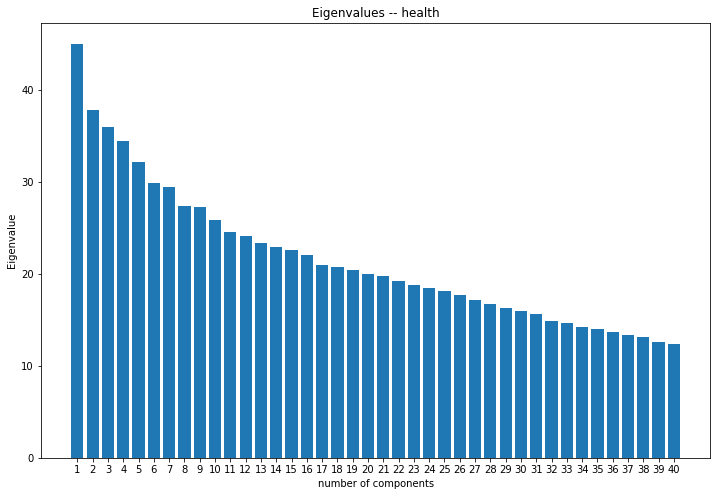

In [66]:
# plot eigenvalues
fig=plt.figure(figsize=(12,8))
plt.bar(np.arange(1,41), pca.singular_values_)
plt.xticks(np.arange(1,41))
plt.title('Eigenvalues -- health')
plt.ylabel('Eigenvalue')
plt.xlabel('number of components')

In [67]:
# clustering Kmeans
pca=PCA(n_components=32, random_state=3)
pca.fit(scaled_health)
pca_health=pca.transform(scaled_health)

km=KMeans(n_clusters=2)
km.fit(pca_health)
pred=km.predict(pca_health)
score=km.score(pca_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
si_score=silhouette_score(pca_health, pred)
ca_score=calinski_harabasz_score(pca_health, pred)
print(-score, ho_score, si_score, ca_score)

18129.145269590423 0.13481675127761072 0.0697095646570036 30.659663378385932


Text(0, 0.5, 'pc2')

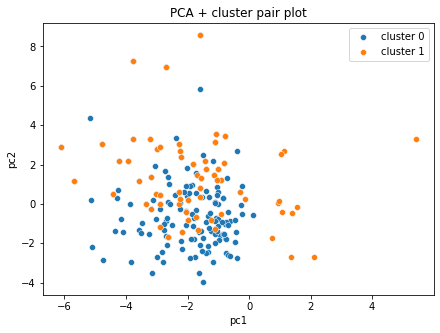

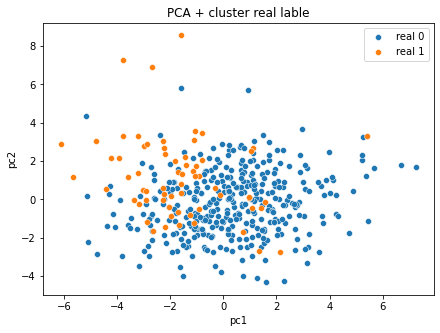

In [76]:
# scatter plot
#print(pca_health)
columns=['pc1','pc2','pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10',
         'pc11','pc12','pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19',
         'pc21','pc22','pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29',
         'pc30', 'pc31', 'pc32', 'pc33']
pca_cluster=pd.DataFrame(data=pca_health, columns=columns)
pca_cluster['cluster label']=pred
pca_cluster['label']=df_health_dn['outcome']
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=pca_cluster[pca_cluster['cluster label']==0]['pc1'], 
                y=pca_cluster[pca_cluster['cluster label']==0]['pc2'], 
                label='cluster 0')
sns.scatterplot(x=pca_cluster[pca_cluster['label']==1]['pc1'], 
                y=pca_cluster[pca_cluster['label']==1]['pc2'], 
                label='cluster 1')
#sns.pairplot(pca_cluster.drop(['cluster label', 'label'], axis=1))
plt.title('PCA + cluster pair plot')

# real label
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=pca_cluster[pca_cluster['label']==0]['pc1'], 
                y=pca_cluster[pca_cluster['label']==0]['pc2'], 
                label='real 0')
sns.scatterplot(x=pca_cluster[pca_cluster['label']==1]['pc1'], 
                y=pca_cluster[pca_cluster['label']==1]['pc2'], 
                label='real 1')
plt.title('PCA + cluster real lable')
plt.xlabel('pc1')
plt.ylabel('pc2')

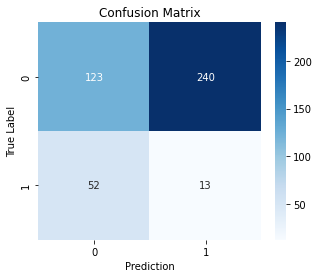

In [254]:
cf_matrix=confusion_matrix(pca_cluster['label'], pca_cluster['cluster label'])
plot_CFmatrix(cf_matrix)

In [177]:
# clustering EM
gm=GaussianMixture(n_components=2)
gm.fit(pca_health)

pred=gm.predict(pca_health)
score=gm.score(pca_health)
aic=gm.aic(pca_health)
bic=gm.bic(pca_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -43.946273467788046
AIC: 39860.01008842657
BIC: 44410.287190673764
homogeneity: 0.07407338522913418


Text(0.5, 1.0, 'PCA + EM pair plot')

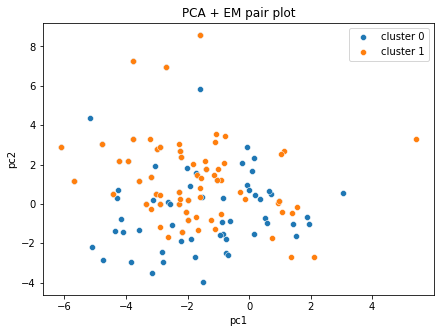

In [179]:
pca_cluster['em label']=pred
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=pca_cluster[pca_cluster['em label']==0]['pc1'], 
                y=pca_cluster[pca_cluster['em label']==0]['pc2'], 
                label='cluster 0')
sns.scatterplot(x=pca_cluster[pca_cluster['label']==1]['pc1'], 
                y=pca_cluster[pca_cluster['label']==1]['pc2'], 
                label='cluster 1')
#sns.pairplot(pca_cluster.drop(['cluster label', 'label'], axis=1))
plt.title('PCA + EM pair plot')

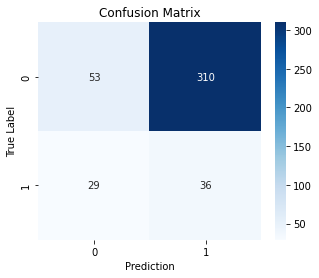

In [255]:
cf_matrix=confusion_matrix(pca_cluster['label'], pca_cluster['em label'])
plot_CFmatrix(cf_matrix)

##### ICA

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tole

Text(0, 0.5, 'Avg Kurtoses')

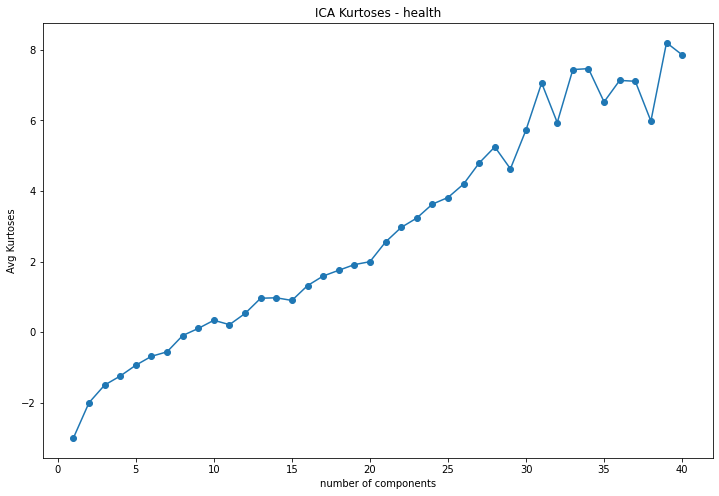

In [180]:
avg_kurs=[]

for i in range(1,41):
  ica=ICA(n_components=i)
  ica.fit(scaled_health)
  kurtose=np.mean(kurt(ica.components_))
  avg_kurs.append(kurtose)

# plot kurtoses
fig=plt.figure(figsize=(12,8))
plt.plot(np.arange(1,41), avg_kurs, marker='o')
plt.title('ICA Kurtoses - health')
plt.xlabel('number of components')
plt.ylabel('Avg Kurtoses')

In [182]:
ica=ICA(n_components=31, max_iter=1000)
ica.fit(scaled_health)
ica_health=ica.transform(scaled_health)

km=KMeans(n_clusters=2)
km.fit(ica_health)
pred=km.predict(ica_health)
score=km.score(ica_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
si_score=silhouette_score(ica_health, pred)
ca_score=calinski_harabasz_score(ica_health, pred)
print(-score, ho_score, si_score, ca_score)

30.018527938803533 0.0002706153915700635 0.08651624252739483 13.928301178594252


Text(0, 0.5, 'ic2')

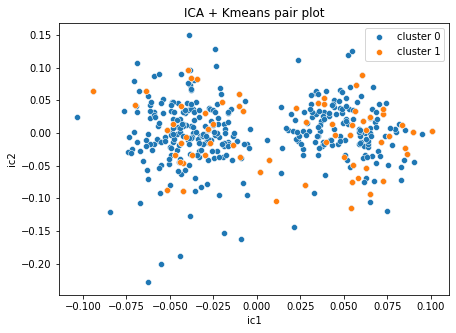

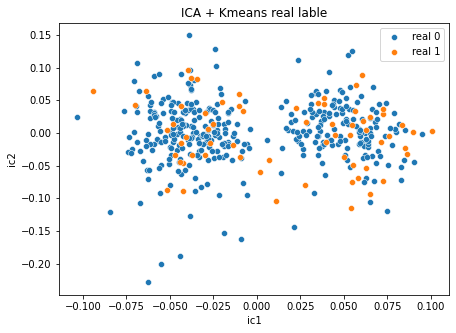

In [183]:
columns=['ic1','ic2','ic3', 'ic4', 'ic5', 'ic6', 'ic7', 'ic8', 'ic9', 'ic10',
         'ic11','ic12','ic13', 'ic14', 'ic15', 'ic16', 'ic17', 'ic18', 'ic19',
         'ic21','ic22','ic23', 'ic24', 'ic25', 'ic26', 'ic27', 'ic28', 'ic29',
         'ic30', 'ic31', 'ic32']
ica_cluster=pd.DataFrame(data=ica_health, columns=columns)
ica_cluster['cluster label']=pred
ica_cluster['label']=df_health_dn['outcome']
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=ica_cluster[ica_cluster['cluster label']==0]['ic1'], 
                y=ica_cluster[ica_cluster['cluster label']==0]['ic2'], 
                label='cluster 0')
sns.scatterplot(x=ica_cluster[ica_cluster['label']==1]['ic1'], 
                y=ica_cluster[ica_cluster['label']==1]['ic2'], 
                label='cluster 1')
#sns.pairplot(pca_cluster.drop(['cluster label', 'label'], axis=1))
plt.title('ICA + Kmeans pair plot')

# real label
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=ica_cluster[ica_cluster['label']==0]['ic1'], 
                y=ica_cluster[ica_cluster['label']==0]['ic2'], 
                label='real 0')
sns.scatterplot(x=ica_cluster[ica_cluster['label']==1]['ic1'], 
                y=ica_cluster[ica_cluster['label']==1]['ic2'], 
                label='real 1')
plt.title('ICA + Kmeans real lable')
plt.xlabel('ic1')
plt.ylabel('ic2')

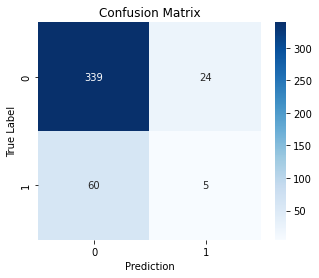

In [257]:
cf_matrix=confusion_matrix(ica_cluster['label'], ica_cluster['cluster label'])
plot_CFmatrix(cf_matrix)

In [184]:
# clustering EM
gm=GaussianMixture(n_components=2)
gm.fit(ica_health)

pred=gm.predict(ica_health)
score=gm.score(ica_health)
aic=gm.aic(ica_health)
bic=gm.bic(ica_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: 53.79032605017627
AIC: -43934.519098950885
BIC: -39652.14412761209
homogeneity: 0.039852994213354344


Text(0, 0.5, 'ic2')

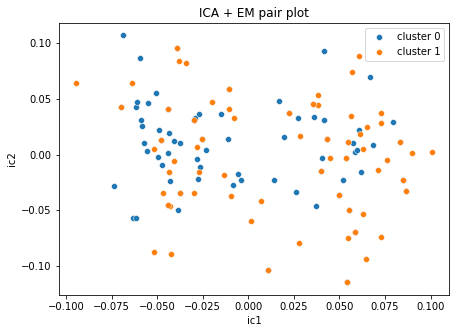

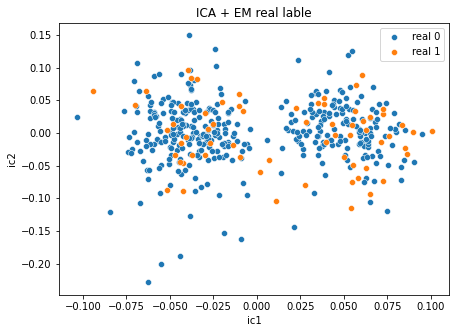

In [185]:
ica_cluster['em label']=pred
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=ica_cluster[ica_cluster['em label']==0]['ic1'], 
                y=ica_cluster[ica_cluster['em label']==0]['ic2'], 
                label='cluster 0')
sns.scatterplot(x=ica_cluster[ica_cluster['label']==1]['ic1'], 
                y=ica_cluster[ica_cluster['label']==1]['ic2'], 
                label='cluster 1')
#sns.pairplot(pca_cluster.drop(['cluster label', 'label'], axis=1))
plt.title('ICA + EM pair plot')

# real label
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=ica_cluster[ica_cluster['label']==0]['ic1'], 
                y=ica_cluster[ica_cluster['label']==0]['ic2'], 
                label='real 0')
sns.scatterplot(x=ica_cluster[ica_cluster['label']==1]['ic1'], 
                y=ica_cluster[ica_cluster['label']==1]['ic2'], 
                label='real 1')
plt.title('ICA + EM real lable')
plt.xlabel('ic1')
plt.ylabel('ic2')

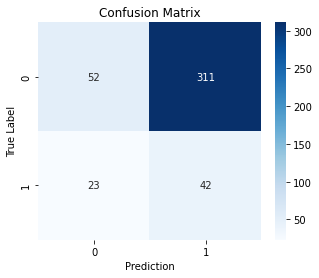

In [258]:
cf_matrix=confusion_matrix(ica_cluster['label'], ica_cluster['em label'])
plot_CFmatrix(cf_matrix)

<Figure size 864x864 with 0 Axes>

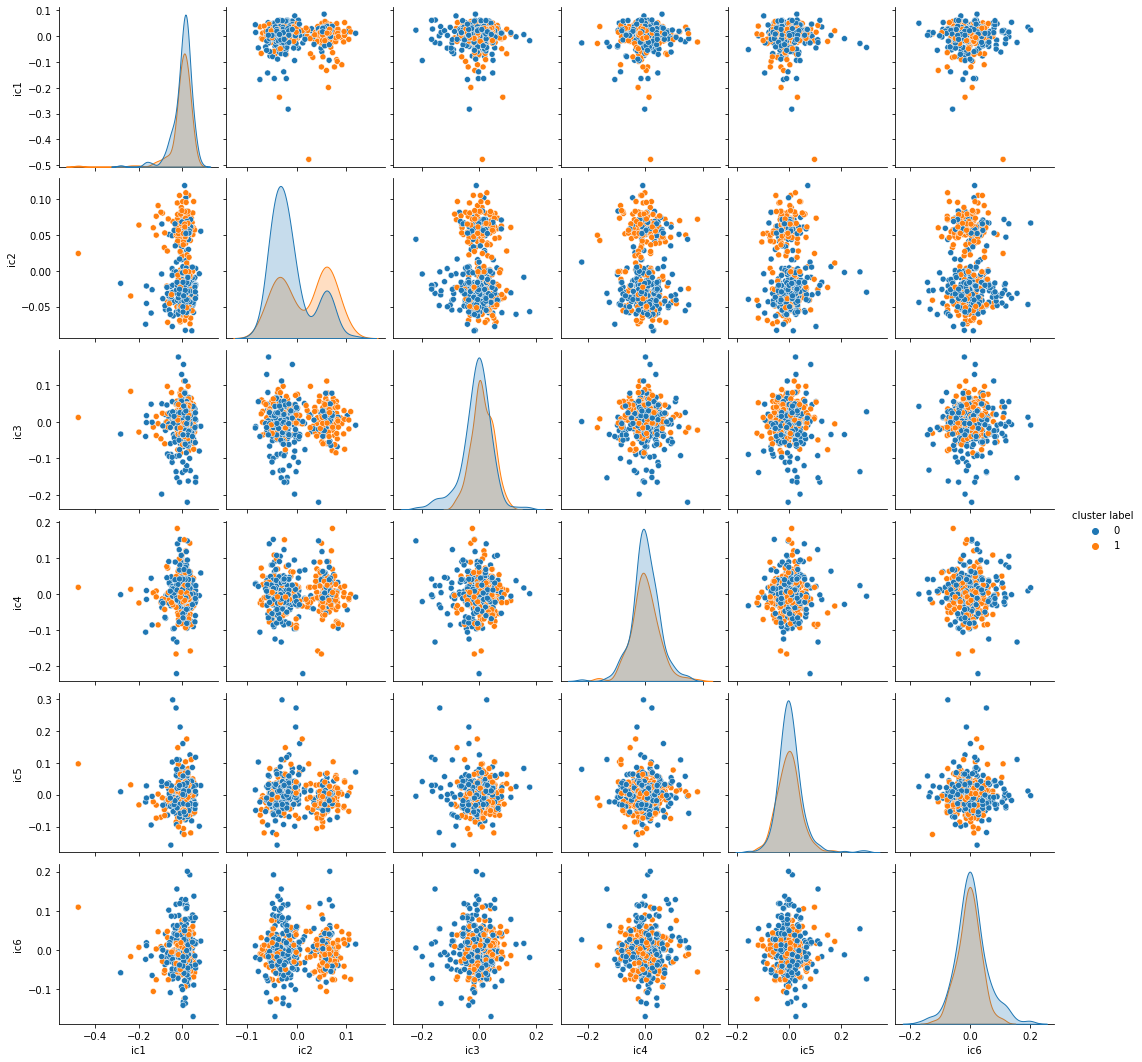

In [91]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(ica_cluster[['ic1','ic2','ic3', 'ic4', 'ic5', 'ic6','cluster label']], hue='cluster label')

<Figure size 864x864 with 0 Axes>

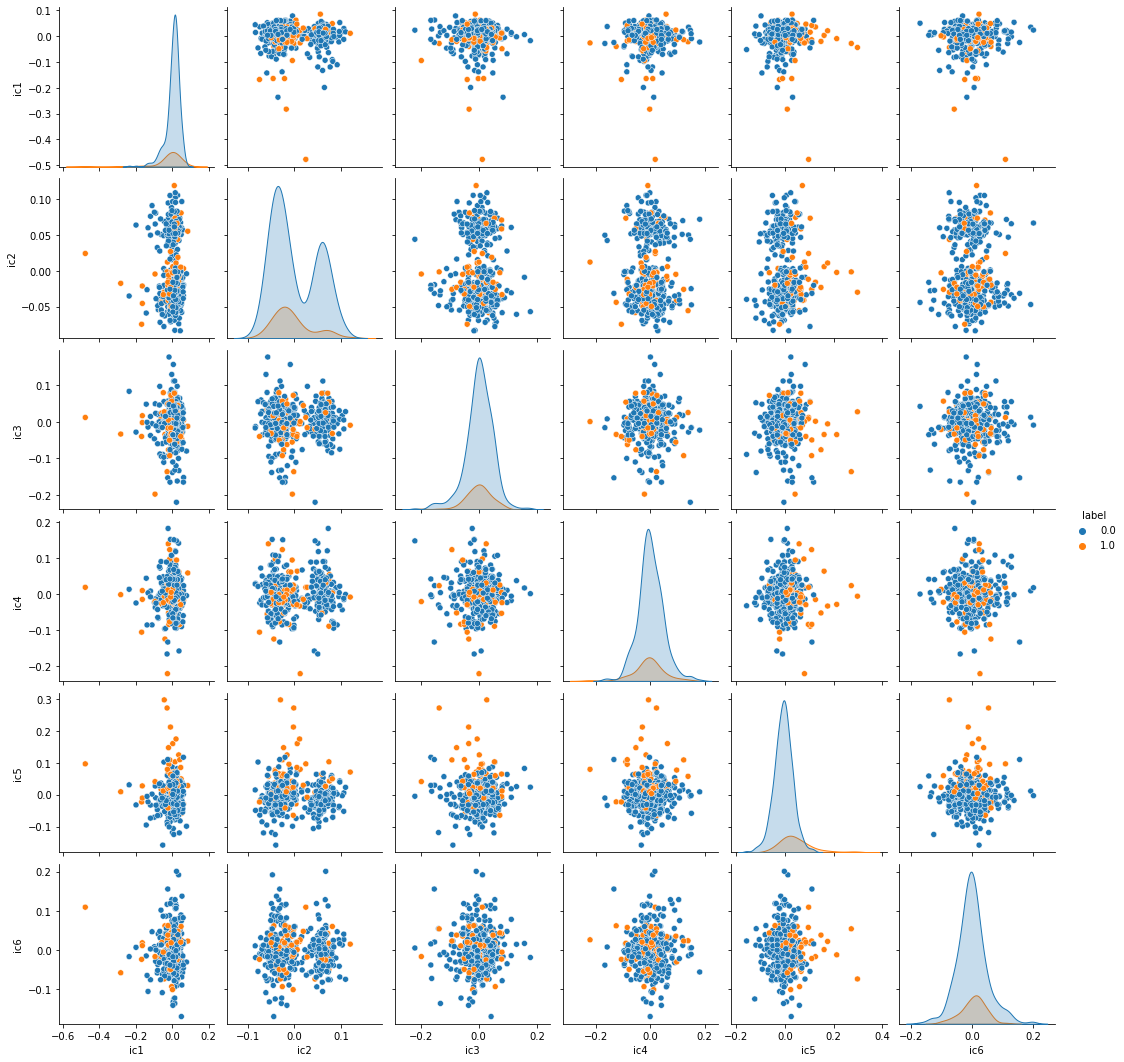

In [92]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(ica_cluster[['ic1','ic2','ic3', 'ic4', 'ic5', 'ic6','label']], hue='label')

##### RPA

Text(0, 0.5, 'reconstruction error')

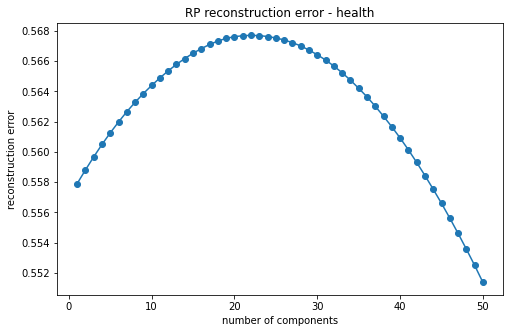

In [109]:
# reconstruction error
def compute_recon(i, X):
  rp=GRP(n_components=i, random_state=3)
  rp.fit(X)
  rp_data=rp.transform(X)
  recon_X=np.dot(rp_data, np.linalg.pinv(rp.components_.T))
  error=np.mean((X-recon_X)**2)
  return error

rec_error_comp=[]
for i in range(1,51):
  rec_erros=[]
  for j in range(10):
    error=compute_recon(i, scaled_health)
    #print(error)
    rec_errors.append(error)
  #print(rec_errors)
  rec_error_comp.append(np.mean(rec_errors))

# plot recon_error
fig=plt.figure(figsize=(8,5))
plt.plot(np.arange(1,51), rec_error_comp, marker='o')
plt.title('RP reconstruction error - health')
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [188]:
# clustering Kmeans
rp=GRP(n_components=50, random_state=3)
rp.fit(scaled_health)
rp_health=rp.transform(scaled_health)

km=KMeans(n_clusters=2)
km.fit(rp_health)
pred=km.predict(rp_health)
score=km.score(rp_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
si_score=silhouette_score(rp_health, pred)
ca_score=calinski_harabasz_score(rp_health, pred)
print(-score, ho_score, si_score, ca_score)

19356.67173677402 0.06888826320103453 0.08192006528875294 41.58952725497954


Text(0, 0.5, 'rp2')

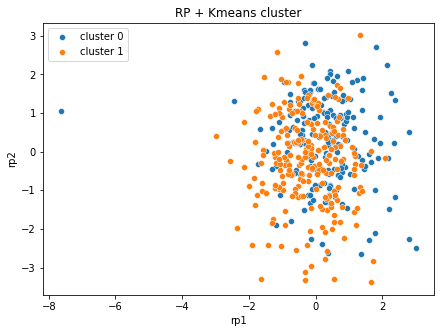

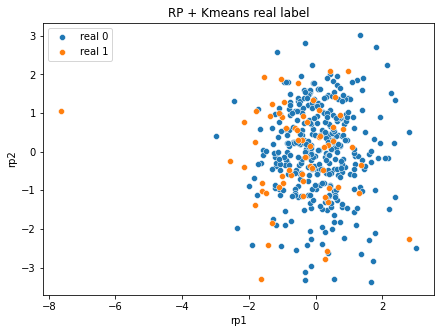

In [189]:
columns=column_names(50, 'rp')
rp_cluster=pd.DataFrame(data=rp_health, columns=columns)
rp_cluster['cluster label']=pred
rp_cluster['label']=df_health_dn['outcome']
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=rp_cluster[rp_cluster['cluster label']==0]['rp1'], 
                y=rp_cluster[rp_cluster['cluster label']==0]['rp2'], 
                label='cluster 0')
sns.scatterplot(x=rp_cluster[rp_cluster['cluster label']==1]['rp1'], 
                y=rp_cluster[rp_cluster['cluster label']==1]['rp2'], 
                label='cluster 1')
#sns.pairplot(pca_cluster.drop(['cluster label', 'label'], axis=1))
plt.title('RP + Kmeans cluster')
plt.xlabel('rp1')
plt.ylabel('rp2')

# real label
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=rp_cluster[rp_cluster['label']==0]['rp1'], 
                y=rp_cluster[rp_cluster['label']==0]['rp2'], 
                label='real 0')
sns.scatterplot(x=rp_cluster[rp_cluster['label']==1]['rp1'], 
                y=rp_cluster[rp_cluster['label']==1]['rp2'], 
                label='real 1')
plt.title('RP + Kmeans real label')
plt.xlabel('rp1')
plt.ylabel('rp2')

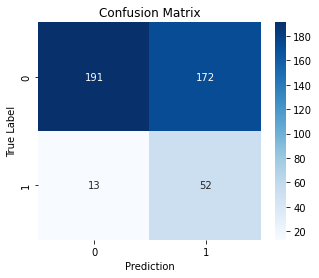

In [260]:
cf_matrix=confusion_matrix(rp_cluster['label'], rp_cluster['cluster label'])
plot_CFmatrix(cf_matrix)

In [190]:
# clustering EM
gm=GaussianMixture(n_components=2)
gm.fit(rp_health)

pred=gm.predict(rp_health)
score=gm.score(rp_health)
aic=gm.aic(rp_health)
bic=gm.bic(rp_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -19.83764076714903
AIC: 22283.020496679568
BIC: 33043.75608816691
homogeneity: 0.03532027757777938


In [191]:
rp_cluster['em label']=pred

In [117]:
rp_cluster.columns

Index(['rp1', 'rp2', 'rp3', 'rp4', 'rp5', 'rp6', 'rp7', 'rp8', 'rp9', 'rp10',
       'rp11', 'rp12', 'rp13', 'rp14', 'rp15', 'rp16', 'rp17', 'rp18', 'rp19',
       'rp20', 'rp21', 'rp22', 'rp23', 'rp24', 'rp25', 'rp26', 'rp27', 'rp28',
       'rp29', 'rp30', 'rp31', 'rp32', 'rp33', 'rp34', 'rp35', 'rp36', 'rp37',
       'rp38', 'rp39', 'rp40', 'rp41', 'rp42', 'rp43', 'rp44', 'rp45', 'rp46',
       'rp47', 'rp48', 'rp49', 'rp50', 'cluster label', 'label'],
      dtype='object')

<Figure size 864x864 with 0 Axes>

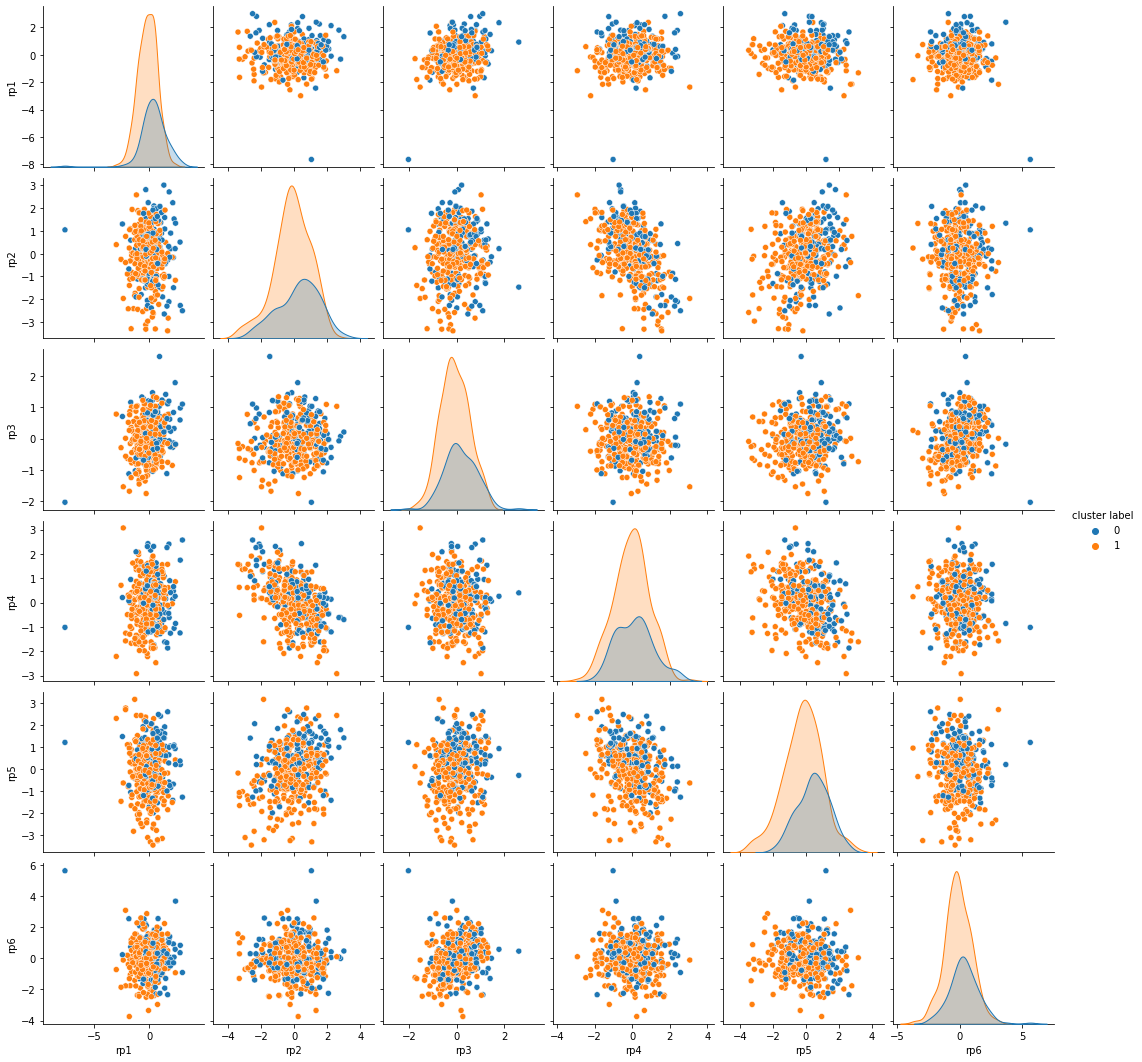

In [118]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(rp_cluster[['rp1', 'rp2', 'rp3', 'rp4', 'rp5', 'rp6','em label']], 
             hue='em label')

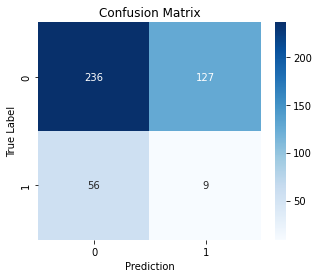

In [261]:
cf_matrix=confusion_matrix(rp_cluster['label'], rp_cluster['em label'])
plot_CFmatrix(cf_matrix)

##### RF

Text(0, 0.5, 'feature importance')

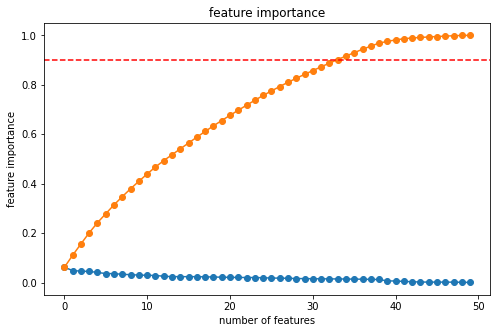

In [192]:
# calculate feature importance
rfc=RandomForestClassifier(n_estimators=200, n_jobs=-1)
rfc.fit(scaled_health,df_health_dn['outcome'])
feature_imp=rfc.feature_importances_
df_imp=pd.DataFrame(data=feature_imp, columns=['imp'])
df_imp['features']=X_health.columns
df_imp=df_imp.sort_values(by=['imp'], ascending=False).reset_index(drop=True)
#print(df_imp)
cum_imp=np.cumsum(df_imp['imp'])
#print(cum_imp)

# plot feature importance
fig=plt.figure(figsize=(8,5))
plt.plot(df_imp.index, df_imp['imp'], marker='o')
plt.plot(df_imp.index, cum_imp, marker='o')
plt.axhline(y=0.9, linestyle='--', color='r')
plt.title('feature importance')
plt.xlabel('number of features')
plt.ylabel('feature importance')

In [193]:
# Clustering Kmeans
sel_features=df_imp['features'][0:34]
rf_health=X_health[sel_features]
#print(sel_features)

km=KMeans(n_clusters=2)
km.fit(rf_health)
pred=km.predict(rf_health)
score=km.score(rf_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
si_score=silhouette_score(rf_health, pred)
ca_score=calinski_harabasz_score(rf_health, pred)
print(-score, ho_score, si_score, ca_score)

172885168054.84174 0.0022348629704461516 0.5274036782748825 690.4563673484489


In [194]:
# plot pairwise
rf_cluster=rf_health.copy()
rf_cluster['cluster label']=pred
rf_cluster['label']=np.array(df_health_dn['outcome'])

<Figure size 864x864 with 0 Axes>

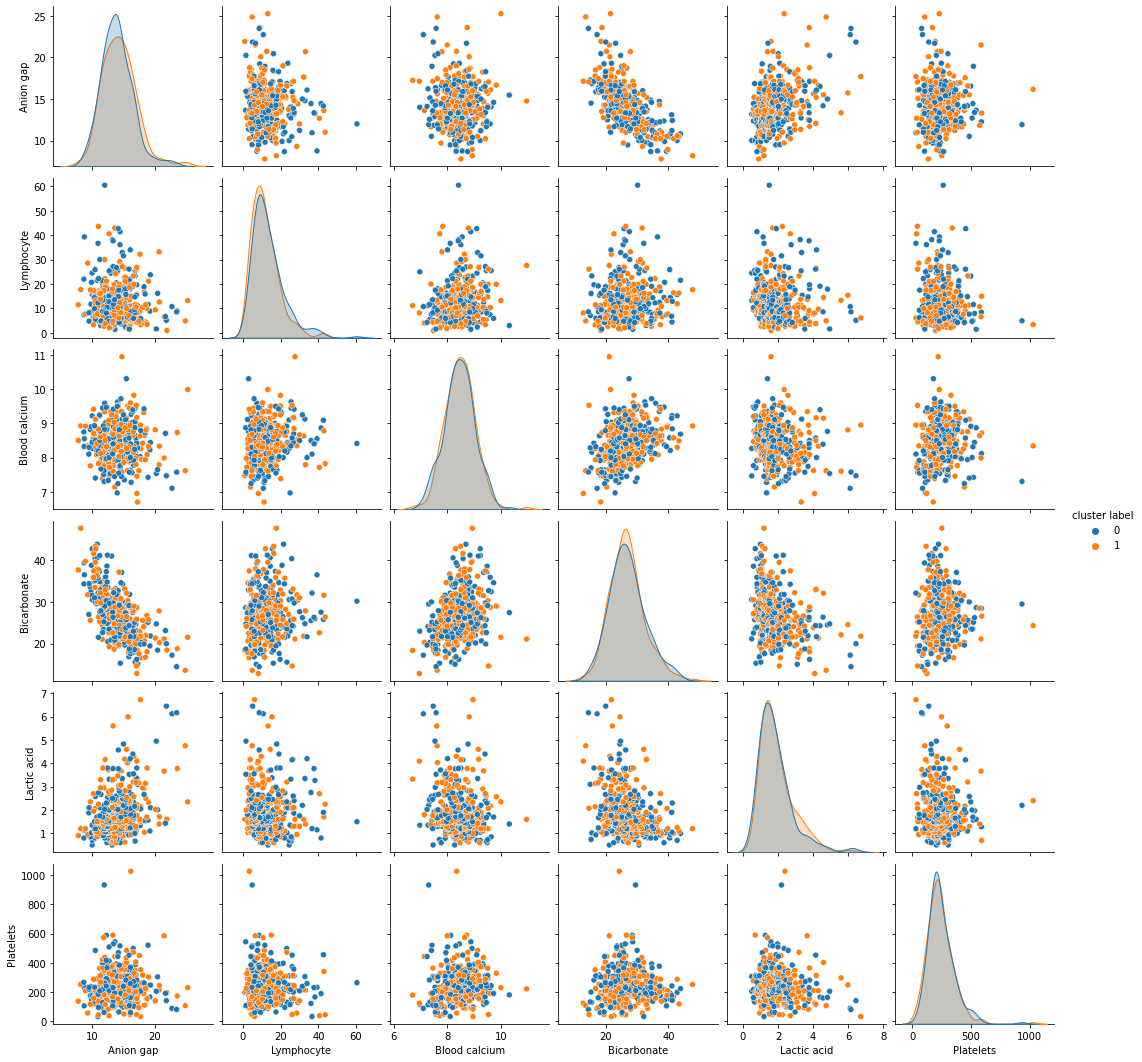

In [265]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(rf_cluster[['Anion gap', 'Lymphocyte', 'Blood calcium', 
                         'Bicarbonate','Lactic acid', 'Platelets','cluster label']], 
             hue='cluster label')

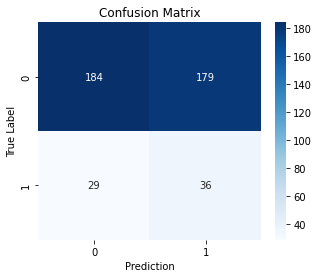

In [262]:
cf_matrix=confusion_matrix(rf_cluster['label'], rf_cluster['cluster label'])
plot_CFmatrix(cf_matrix)

In [195]:
# Clustering EM
gm=GaussianMixture(n_components=2)
gm.fit(rf_health)

pred=gm.predict(rf_health)
score=gm.score(rf_health)
aic=gm.aic(rf_health)
bic=gm.bic(rf_health)
ho_score=homogeneity_score(df_health_dn['outcome'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -101.71977809446355
AIC: 89590.1300488608
BIC: 94700.56615209828
homogeneity: 0.05427806628123606


In [196]:
rf_cluster['em label']=pred

In [132]:
rf_health.columns

Index(['Anion gap', 'Lymphocyte', 'Blood calcium', 'Bicarbonate',
       'Lactic acid', 'Platelets', 'Urea nitrogen', 'Neutrophils',
       'Urine output', 'Leucocyte', 'INR', 'PT', 'heart rate',
       'Blood potassium', 'NT-proBNP', 'temperature', 'Respiratory rate', 'PH',
       'glucose', 'PCO2', 'MCV', 'Blood sodium', 'RBC', 'RDW', 'age',
       'Magnesium ion', 'hematocrit', 'Creatine kinase', 'Chloride', 'ID',
       'SP O2', 'Creatinine', 'Systolic blood pressure', 'MCH'],
      dtype='object')

<Figure size 864x864 with 0 Axes>

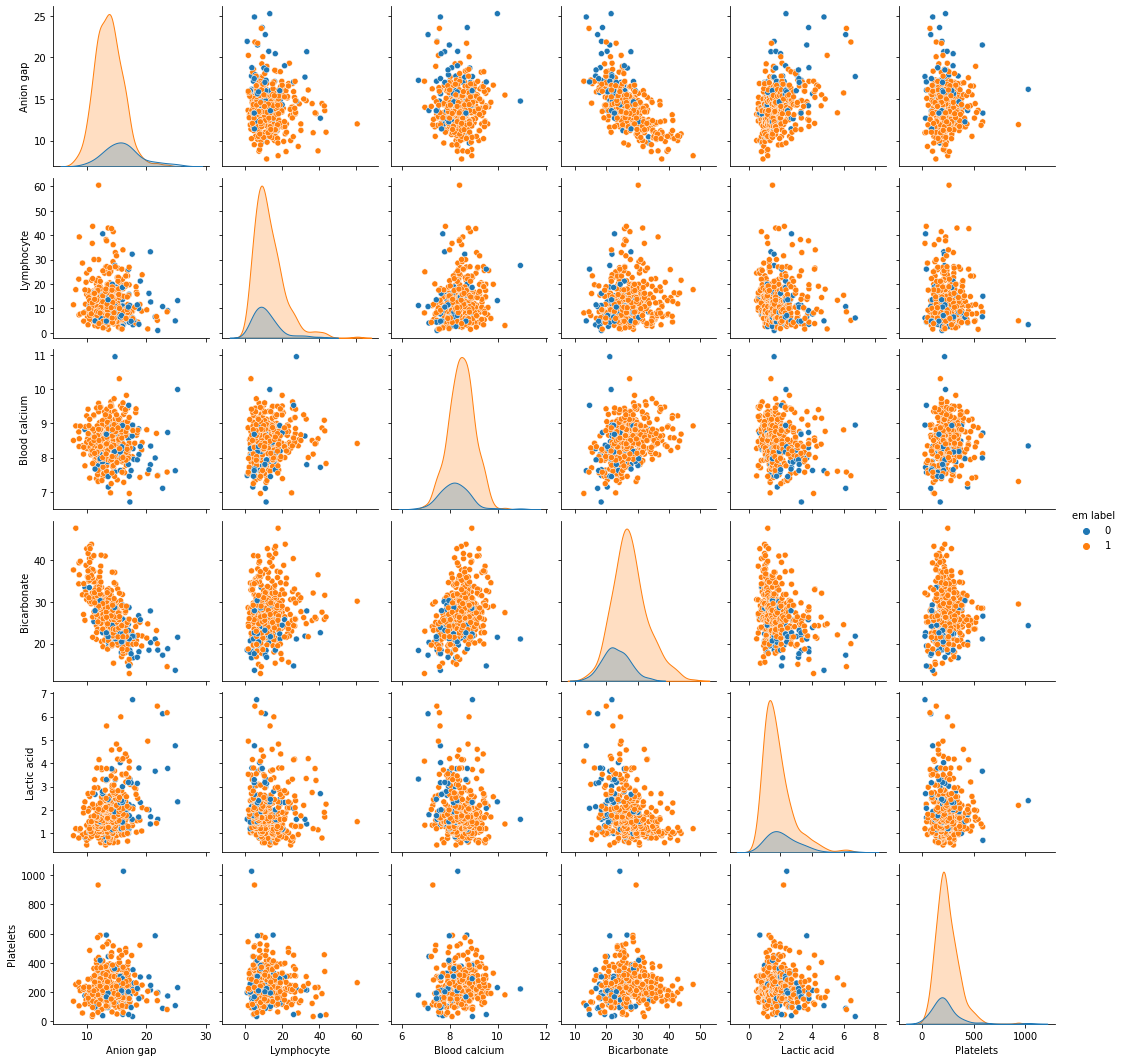

In [264]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(rf_cluster[['Anion gap', 'Lymphocyte', 'Blood calcium', 
                         'Bicarbonate','Lactic acid', 'Platelets','em label']], 
             hue='em label')

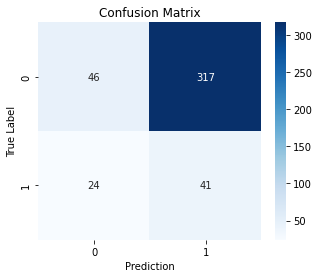

In [263]:
cf_matrix=confusion_matrix(rf_cluster['label'], rf_cluster['em label'])
plot_CFmatrix(cf_matrix)

#### Titanic

##### PCA

Text(0.5, 0, 'number of components')

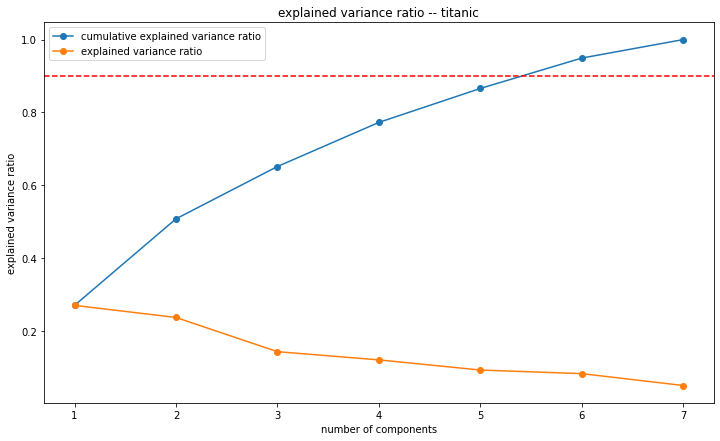

In [209]:
pca=PCA(n_components=7, random_state=3)
pca.fit(scaled_titanic)

varr_cum=np.cumsum(pca.explained_variance_ratio_)

# plot explained variance ratio
fig=plt.figure(figsize=(12,7))
plt.plot(np.arange(1,8), varr_cum, marker='o', label='cumulative explained variance ratio')
plt.plot(np.arange(1,8), pca.explained_variance_ratio_, marker='o', 
         label='explained variance ratio')
plt.legend()
plt.xticks(np.arange(1,8))
plt.axhline(y=0.9, linestyle='--', color='r')
plt.title('explained variance ratio -- titanic')
plt.ylabel('explained variance ratio')
plt.xlabel('number of components')

Text(0.5, 0, 'number of components')

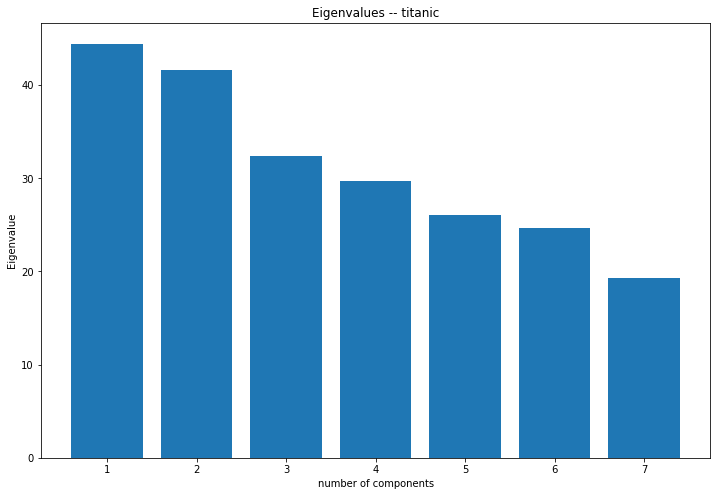

In [210]:
fig=plt.figure(figsize=(12,8))
plt.bar(np.arange(1,8), pca.singular_values_)
plt.xticks(np.arange(1,8))
plt.title('Eigenvalues -- titanic')
plt.ylabel('Eigenvalue')
plt.xlabel('number of components')

In [212]:
# clustering Kmeans
pca=PCA(n_components=6, random_state=3)
pca.fit(scaled_titanic)
pca_titanic=pca.transform(scaled_titanic)

km=KMeans(n_clusters=2)
km.fit(pca_titanic)
pred=km.predict(pca_titanic)
score=km.score(pca_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
si_score=silhouette_score(pca_titanic, pred)
ca_score=calinski_harabasz_score(pca_titanic, pred)
print(-score, ho_score, si_score, ca_score)

5524.090230692378 0.043681102834767505 0.260323290005829 265.01456452435485


Text(0.5, 1.0, 'PCA + Kmeans pair plot')

<Figure size 504x360 with 0 Axes>

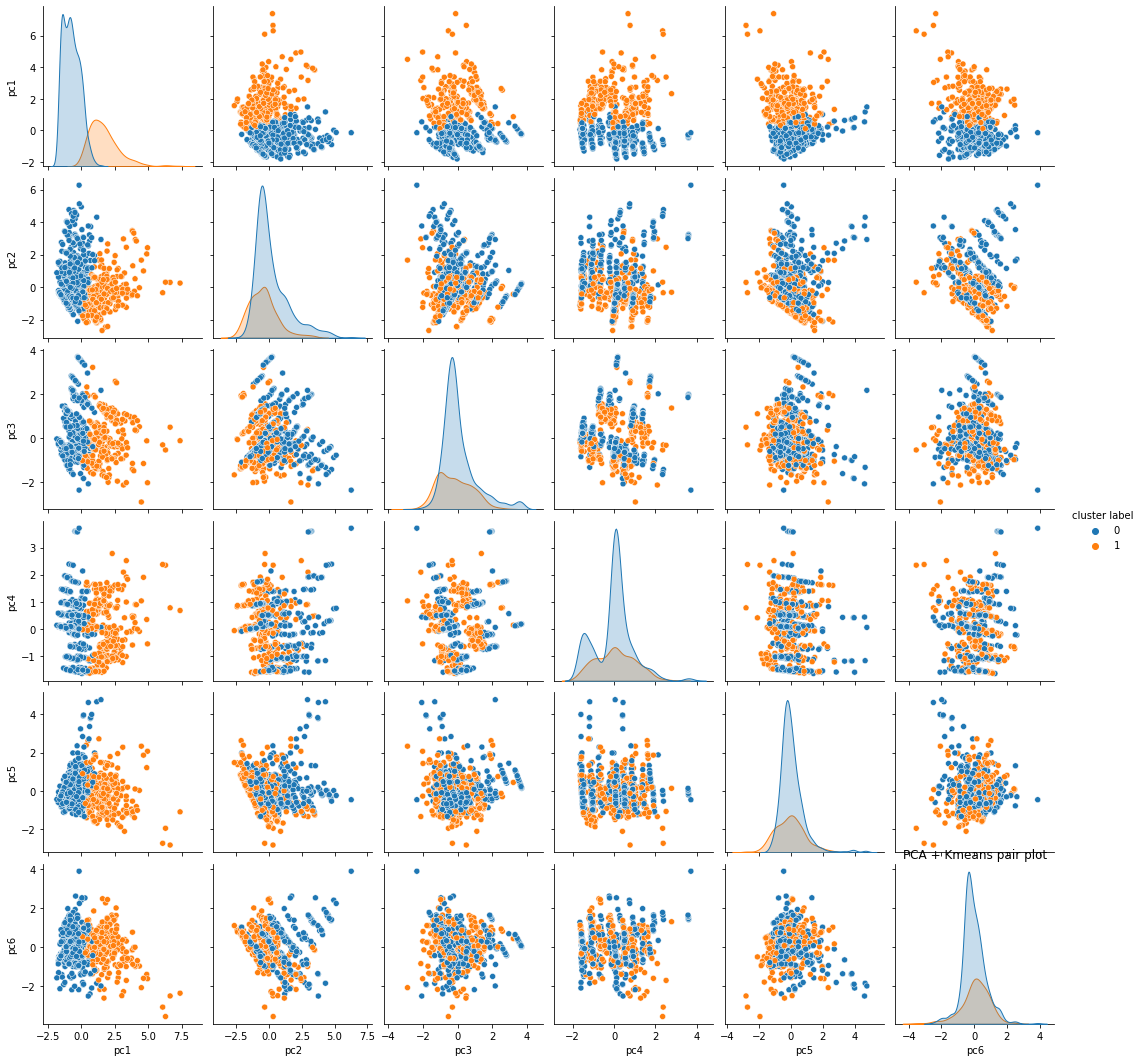

In [213]:
# scatter plot
#print(pca_health)
columns=['pc1','pc2','pc3', 'pc4', 'pc5', 'pc6']
pca_cluster_t=pd.DataFrame(data=pca_titanic, columns=columns)
pca_cluster_t['cluster label']=pred
pca_cluster_t['label']=df_titanic_f['Survived']
fig=plt.figure(figsize=(12,12))
sns.pairplot(pca_cluster_t.drop('label',axis=1), hue='cluster label')
plt.title('PCA + Kmeans pair plot')

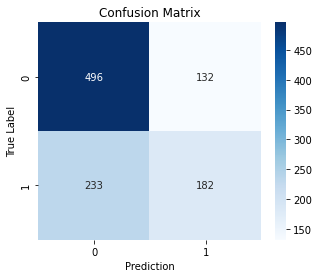

In [215]:
cf_matrix=confusion_matrix(pca_cluster_t['label'], pca_cluster_t['cluster label'])
plot_CFmatrix(cf_matrix)

In [216]:
gm=GaussianMixture(n_components=2)
gm.fit(pca_titanic)

pred=gm.predict(pca_titanic)
score=gm.score(pca_titanic)
aic=gm.aic(pca_titanic)
bic=gm.bic(pca_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -6.154580747563715
AIC: 12948.45543941791
BIC: 13220.697544442954
homogeneity: 0.05108203619834646


In [217]:
pca_cluster_t['em label']=pred

Text(0.5, 1.0, 'PCA + EM pair plot')

<Figure size 864x864 with 0 Axes>

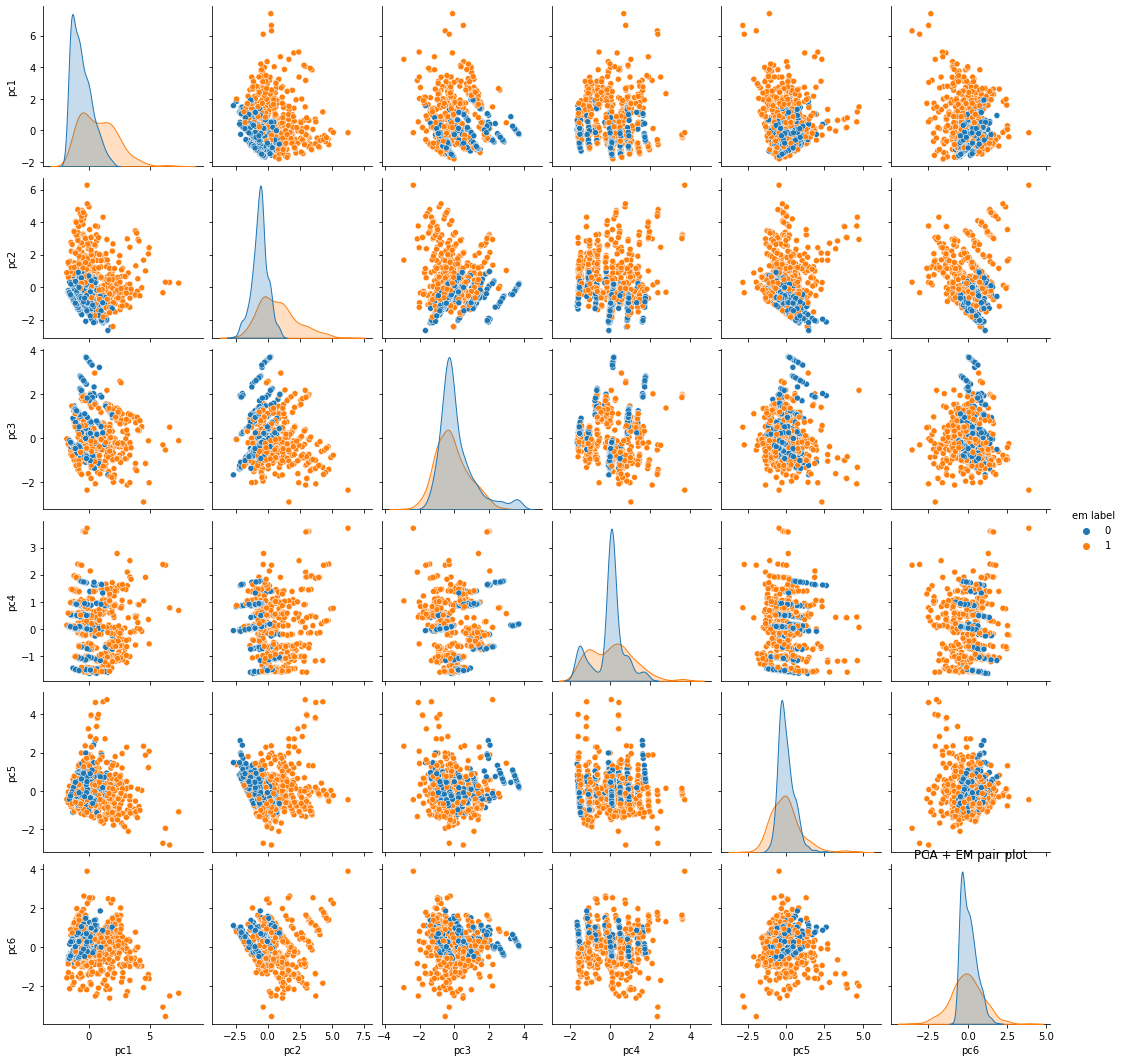

In [220]:
# scatter plot
fig=plt.figure(figsize=(12,12))
sns.pairplot(pca_cluster_t.drop(['cluster label', 'label'],axis=1), hue='em label')
plt.title('PCA + EM pair plot')

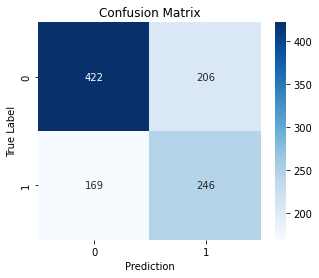

In [219]:
cf_matrix=confusion_matrix(pca_cluster_t['label'], pca_cluster_t['em label'])
plot_CFmatrix(cf_matrix)

##### ICA

Text(0, 0.5, 'Avg Kurtoses')

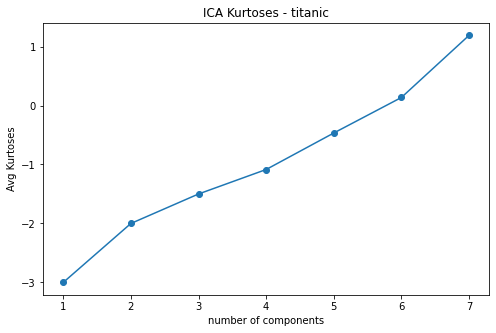

In [224]:
avg_kurs=[]

for i in range(1,8):
  ica=ICA(n_components=i)
  ica.fit(scaled_titanic)
  kurtose=np.mean(kurt(ica.components_))
  avg_kurs.append(kurtose)

# plot kurtoses
fig=plt.figure(figsize=(8,5))
plt.plot(np.arange(1,8), avg_kurs, marker='o')
plt.title('ICA Kurtoses - titanic')
plt.xlabel('number of components')
plt.ylabel('Avg Kurtoses')

In [226]:
ica=ICA(n_components=7, max_iter=1000)
ica.fit(scaled_titanic)
ica_titanic=ica.transform(scaled_titanic)

km=KMeans(n_clusters=2)
km.fit(ica_titanic)
pred=km.predict(ica_titanic)
score=km.score(ica_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
si_score=silhouette_score(ica_titanic, pred)
ca_score=calinski_harabasz_score(ica_titanic, pred)
print(-score, ho_score, si_score, ca_score)

5.999999999999998 0.37053635072313085 0.2194494546388498 173.5000000000001


In [227]:
columns=['ic1','ic2','ic3', 'ic4', 'ic5', 'ic6','ic7']
ica_cluster_t=pd.DataFrame(data=ica_titanic, columns=columns)
ica_cluster_t['cluster label']=pred
ica_cluster_t['label']=df_titanic_f['Survived']

Text(0.5, 1.0, 'ICA + Kmeans pair plot')

<Figure size 864x864 with 0 Axes>

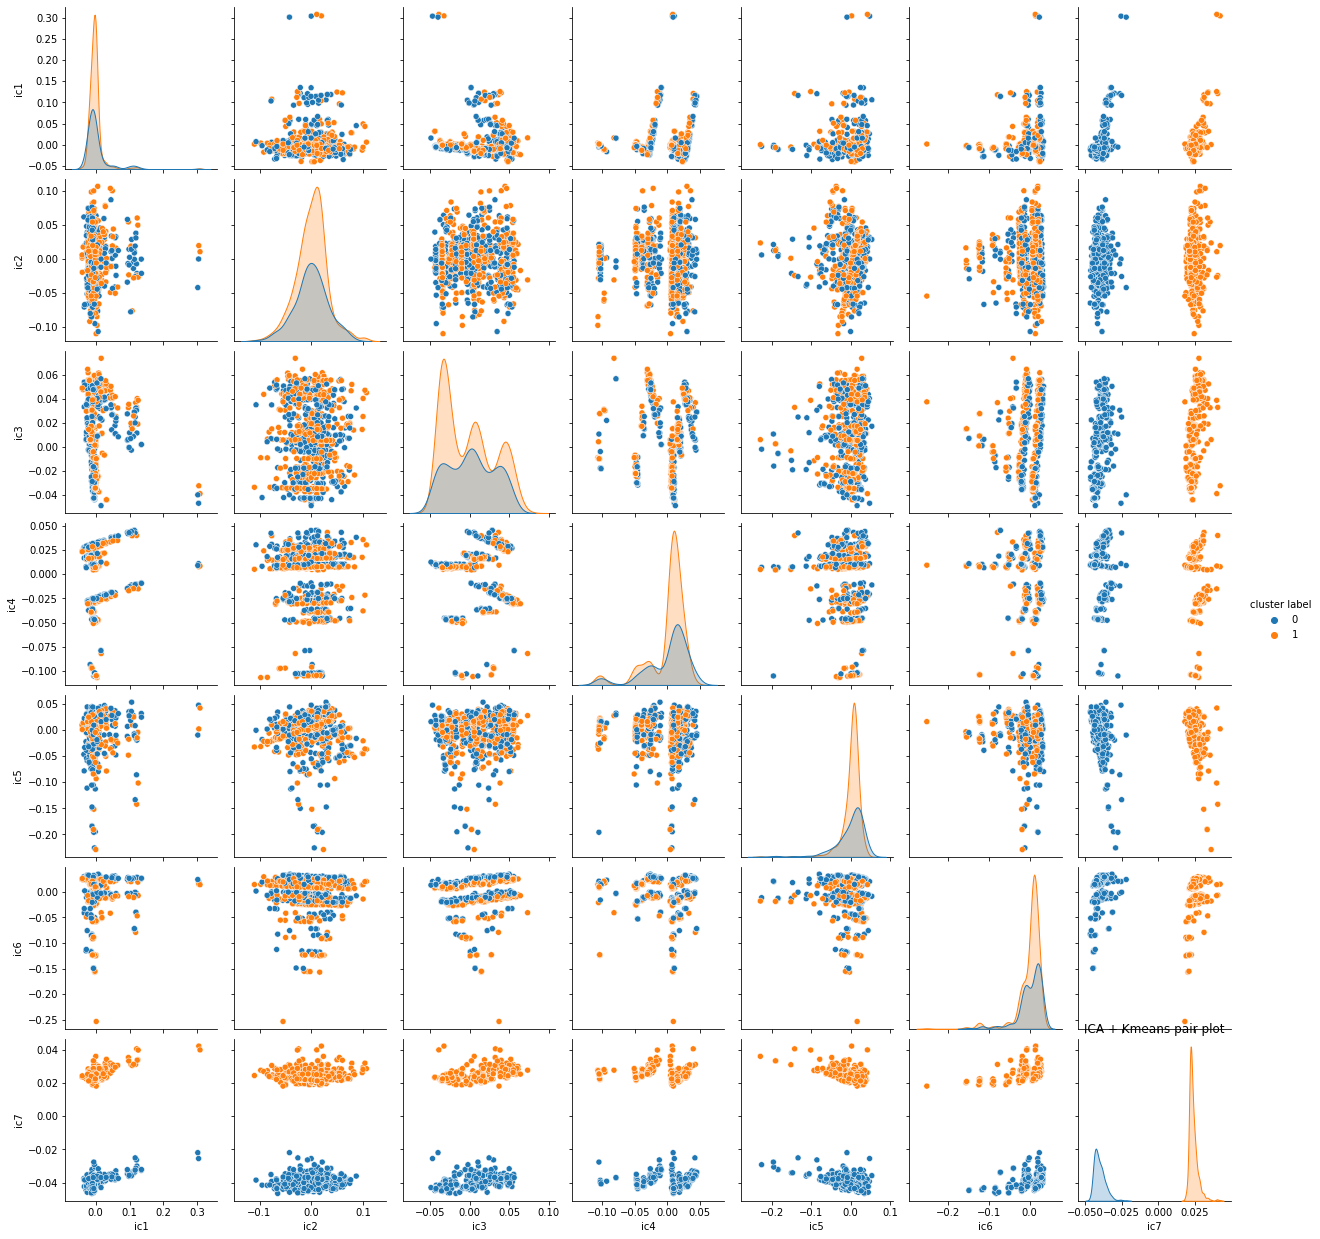

In [228]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(ica_cluster_t.drop('label',axis=1), hue='cluster label')
plt.title('ICA + Kmeans pair plot')

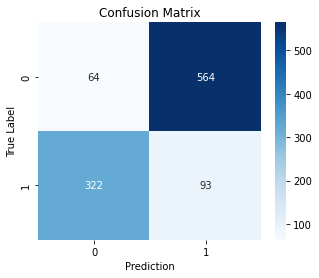

In [229]:
cf_matrix=confusion_matrix(ica_cluster_t['label'], ica_cluster_t['cluster label'])
plot_CFmatrix(cf_matrix)

In [230]:
gm=GaussianMixture(n_components=2)
gm.fit(ica_titanic)

pred=gm.predict(ica_titanic)
score=gm.score(ica_titanic)
aic=gm.aic(ica_titanic)
bic=gm.bic(ica_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: 16.430748443219677
AIC: -34132.54125255625
BIC: -33781.101444251195
homogeneity: 0.04443330075404816


In [231]:
ica_cluster_t['em label']=pred

Text(0.5, 1.0, 'ICA + EM pair plot')

<Figure size 864x864 with 0 Axes>

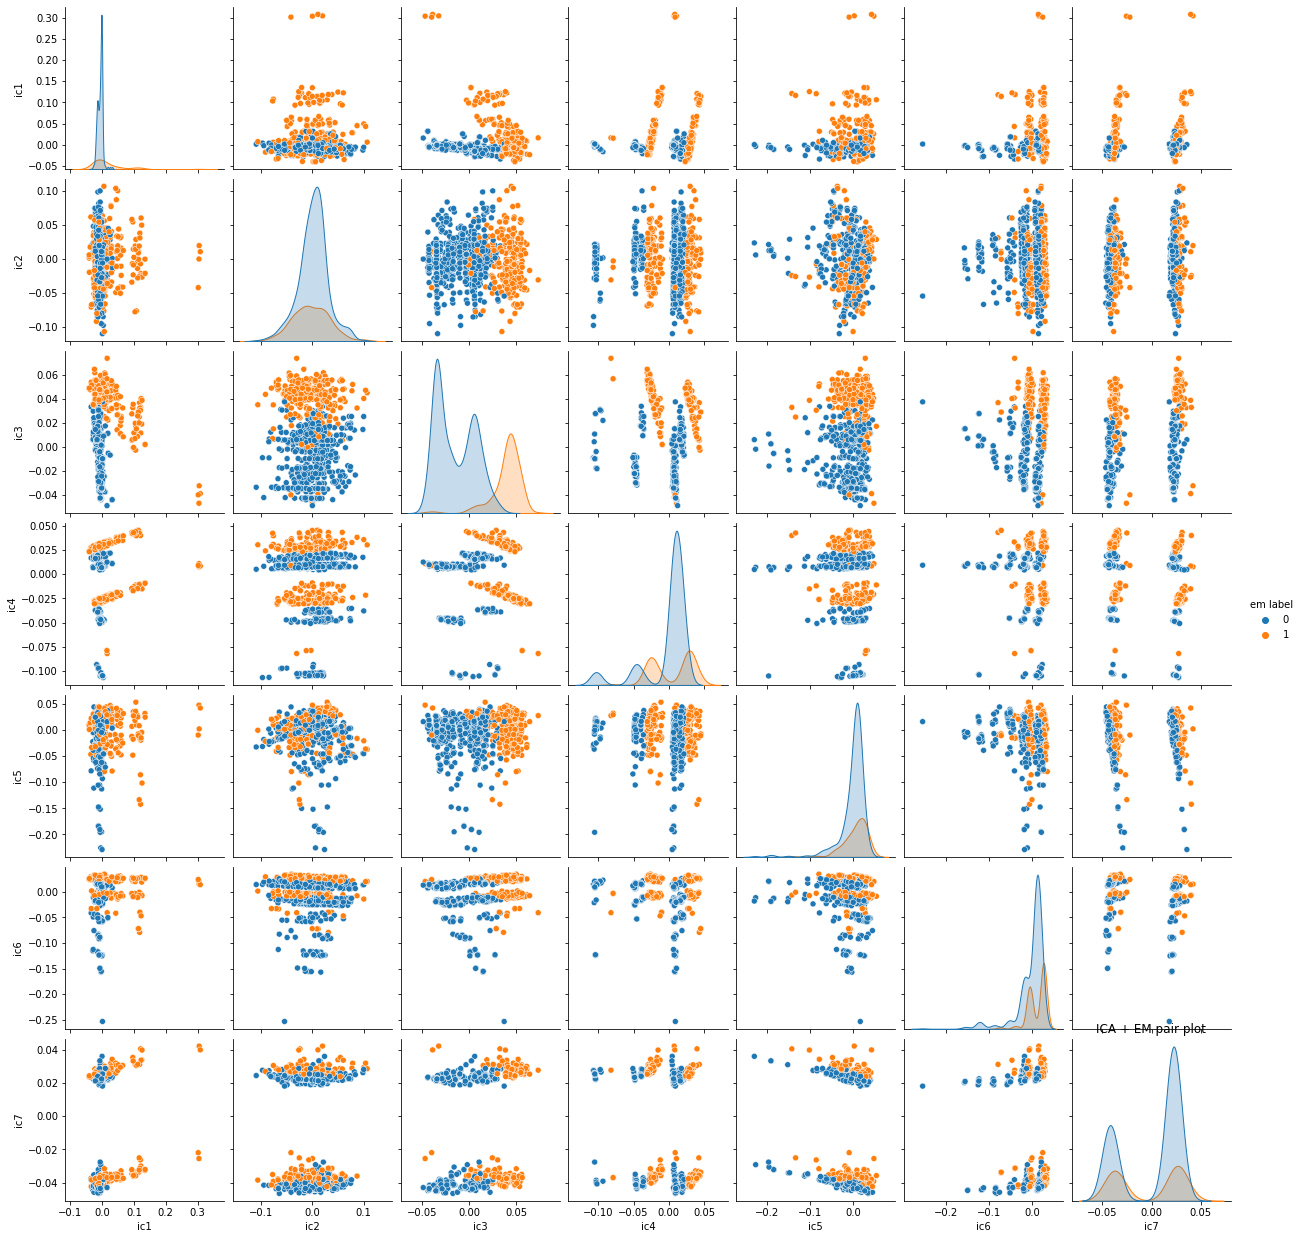

In [232]:
# scatter plot
fig=plt.figure(figsize=(12,12))
sns.pairplot(ica_cluster_t.drop(['cluster label', 'label'],axis=1), hue='em label')
plt.title('ICA + EM pair plot')

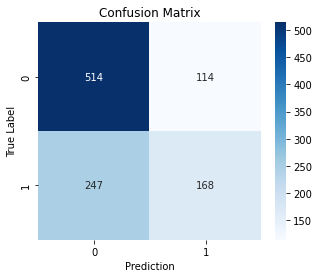

In [233]:
cf_matrix=confusion_matrix(ica_cluster_t['label'], ica_cluster_t['em label'])
plot_CFmatrix(cf_matrix)

##### RP

Text(0, 0.5, 'reconstruction error')

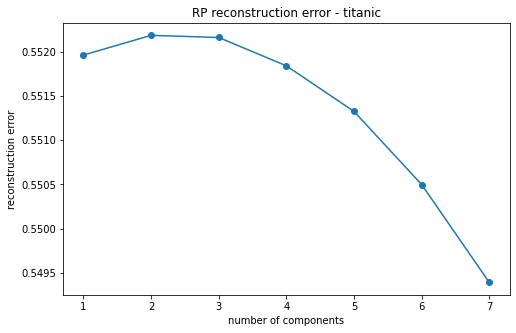

In [234]:
rec_error_comp=[]
for i in range(1,8):
  rec_erros=[]
  for j in range(10):
    error=compute_recon(i, scaled_titanic)
    rec_errors.append(error)
  #print(rec_errors)
  rec_error_comp.append(np.mean(rec_errors))

# plot recon_error
fig=plt.figure(figsize=(8,5))
plt.plot(np.arange(1,8), rec_error_comp, marker='o')
plt.title('RP reconstruction error - titanic')
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [235]:
# clustering Kmeans
rp=GRP(n_components=5, random_state=3)
rp.fit(scaled_titanic)
rp_titanic=rp.transform(scaled_titanic)

km=KMeans(n_clusters=2)
km.fit(rp_titanic)
pred=km.predict(rp_titanic)
score=km.score(rp_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
si_score=silhouette_score(rp_titanic, pred)
ca_score=calinski_harabasz_score(rp_titanic, pred)
print(-score, ho_score, si_score, ca_score)

4551.42710307042 0.014739541086680935 0.4109967872350991 505.63215424407235


In [237]:
columns=column_names(5, 'rp')
rp_cluster_t=pd.DataFrame(data=rp_titanic, columns=columns)
rp_cluster_t['cluster label']=pred
rp_cluster_t['label']=df_titanic_f['Survived']

Text(0.5, 1.0, 'RP + Kmeans pair plot')

<Figure size 864x864 with 0 Axes>

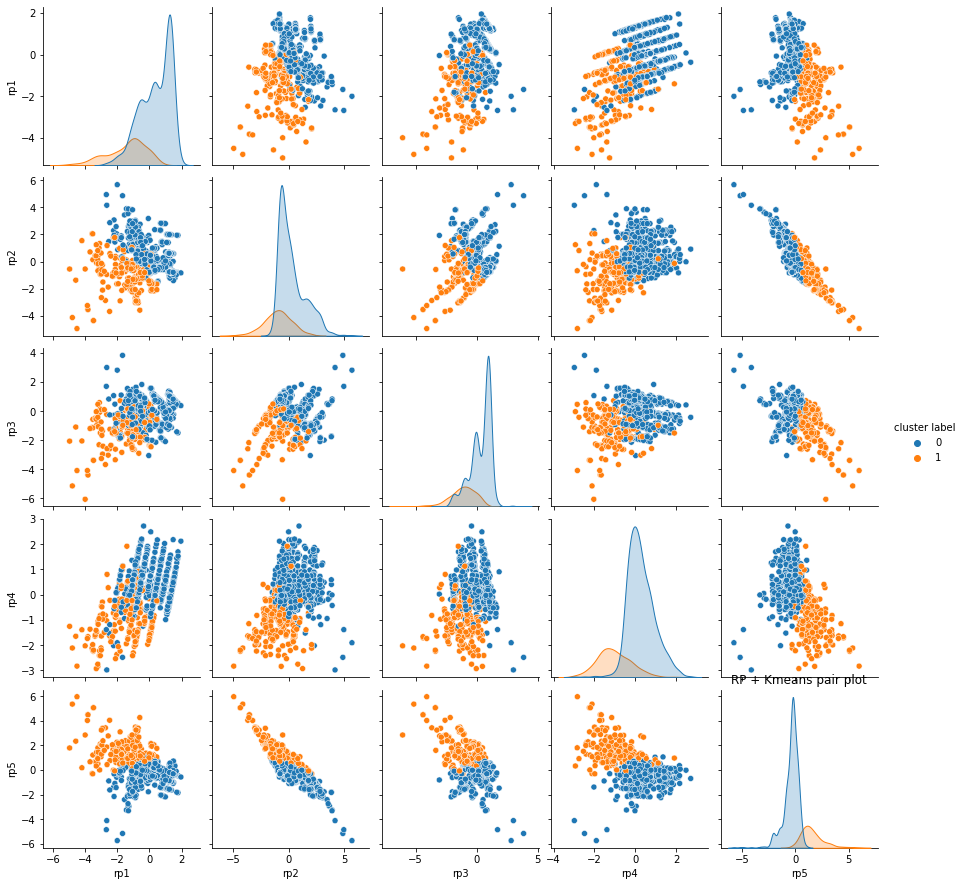

In [238]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(rp_cluster_t.drop('label',axis=1), hue='cluster label')
plt.title('RP + Kmeans pair plot')

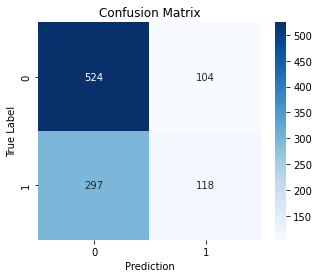

In [239]:
cf_matrix=confusion_matrix(rp_cluster_t['label'], rp_cluster_t['cluster label'])
plot_CFmatrix(cf_matrix)

In [240]:
gm=GaussianMixture(n_components=2)
gm.fit(rp_titanic)

pred=gm.predict(rp_titanic)
score=gm.score(rp_titanic)
aic=gm.aic(rp_titanic)
bic=gm.bic(rp_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -4.564462147359217
AIC: 9603.468039391328
BIC: 9806.41215404636
homogeneity: 0.050398704218118665


In [241]:
rp_cluster_t['em label']=pred

Text(0.5, 1.0, 'RP + EM pair plot')

<Figure size 864x864 with 0 Axes>

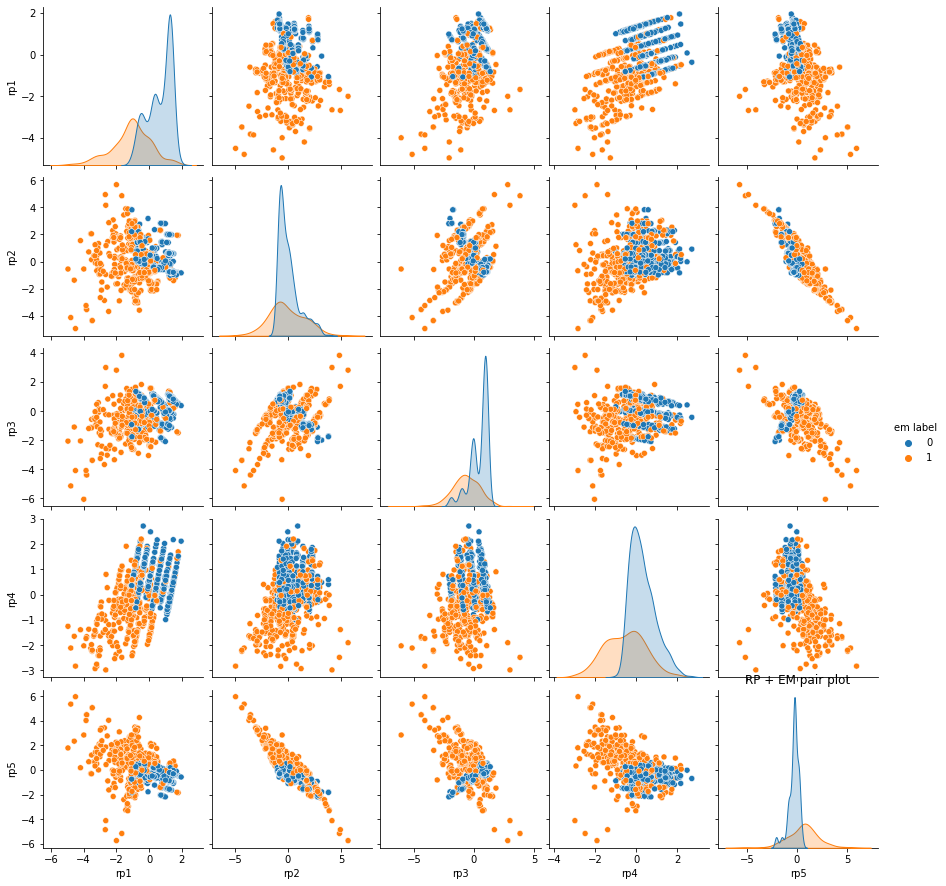

In [242]:
# scatter plot
fig=plt.figure(figsize=(12,12))
sns.pairplot(rp_cluster_t.drop(['cluster label', 'label'],axis=1), hue='em label')
plt.title('RP + EM pair plot')

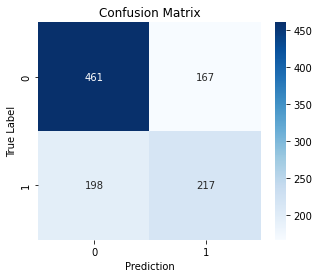

In [243]:
cf_matrix=confusion_matrix(rp_cluster_t['label'], rp_cluster_t['em label'])
plot_CFmatrix(cf_matrix)

##### RF

Text(0, 0.5, 'feature importance')

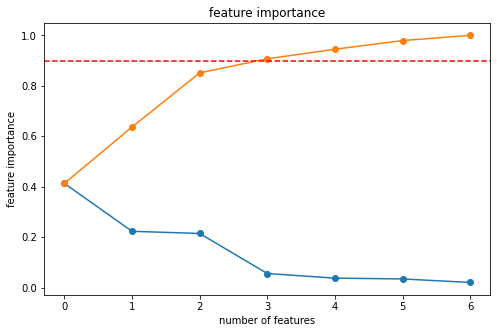

In [244]:
# calculate feature importance
rfc=RandomForestClassifier(n_estimators=200, n_jobs=-1)
rfc.fit(scaled_titanic,df_titanic_f['Survived'])
feature_imp=rfc.feature_importances_
df_imp=pd.DataFrame(data=feature_imp, columns=['imp'])
df_imp['features']=X_titanic.columns
df_imp=df_imp.sort_values(by=['imp'], ascending=False).reset_index(drop=True)
#print(df_imp)
cum_imp=np.cumsum(df_imp['imp'])
#print(cum_imp)

# plot feature importance
fig=plt.figure(figsize=(8,5))
plt.plot(df_imp.index, df_imp['imp'], marker='o')
plt.plot(df_imp.index, cum_imp, marker='o')
plt.axhline(y=0.9, linestyle='--', color='r')
plt.title('feature importance')
plt.xlabel('number of features')
plt.ylabel('feature importance')

In [245]:
# Clustering Kmeans
sel_features=df_imp['features'][0:4]
rf_titanic=X_titanic[sel_features]
#print(sel_features)

km=KMeans(n_clusters=2)
km.fit(rf_titanic)
pred=km.predict(rf_titanic)
score=km.score(rf_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
si_score=silhouette_score(rf_titanic, pred)
ca_score=calinski_harabasz_score(rf_titanic, pred)
print(-score, ho_score, si_score, ca_score)

1285220.3362504388 0.019268275720557025 0.7983849710760546 1757.5237894517816


In [246]:
# plot pairwise
rf_cluster_t=rf_titanic.copy()
rf_cluster_t['cluster label']=pred
rf_cluster_t['label']=np.array(df_titanic_f['Survived'])

Text(0.5, 1.0, 'RF + Kmeans pair plot')

<Figure size 864x864 with 0 Axes>

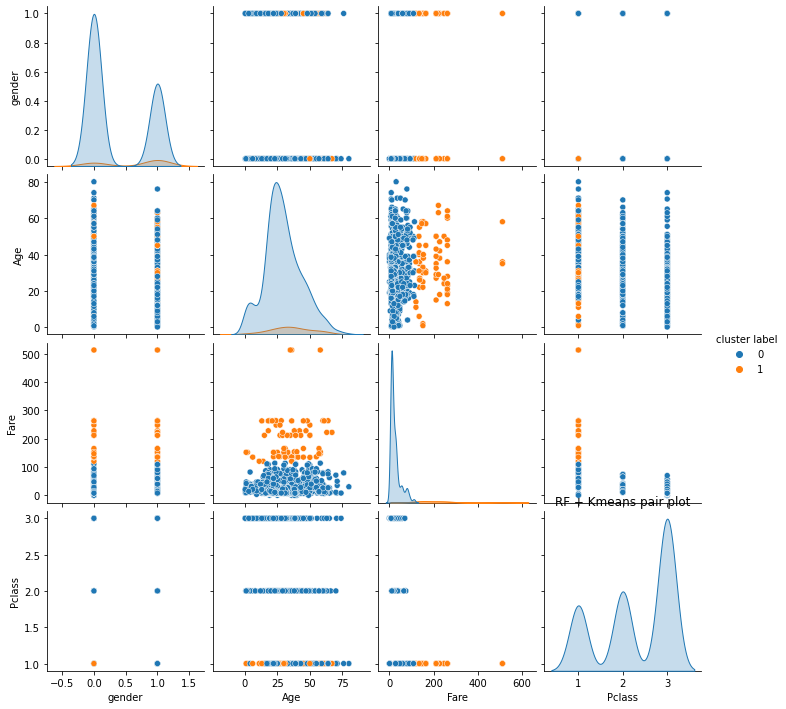

In [247]:
fig=plt.figure(figsize=(12,12))
sns.pairplot(rf_cluster_t.drop('label',axis=1), hue='cluster label')
plt.title('RF + Kmeans pair plot')

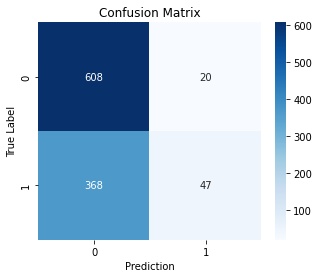

In [248]:
cf_matrix=confusion_matrix(rf_cluster_t['label'], rf_cluster_t['cluster label'])
plot_CFmatrix(cf_matrix)

In [249]:
# Clustering EM
gm=GaussianMixture(n_components=2)
gm.fit(rf_titanic)

pred=gm.predict(rf_titanic)
score=gm.score(rf_titanic)
aic=gm.aic(rf_titanic)
bic=gm.bic(rf_titanic)
ho_score=homogeneity_score(df_titanic_f['Survived'], pred)
print('score: {}'.format(score))
print('AIC: {}'.format(aic))
print('BIC: {}'.format(bic))
print('homogeneity: {}'.format(ho_score))

score: -8.457110212433902
AIC: 17699.53190313712
BIC: 17843.07774033214
homogeneity: 0.04443330075404816


In [250]:
rf_cluster_t['em label']=pred

Text(0.5, 1.0, 'RF + EM pair plot')

<Figure size 864x864 with 0 Axes>

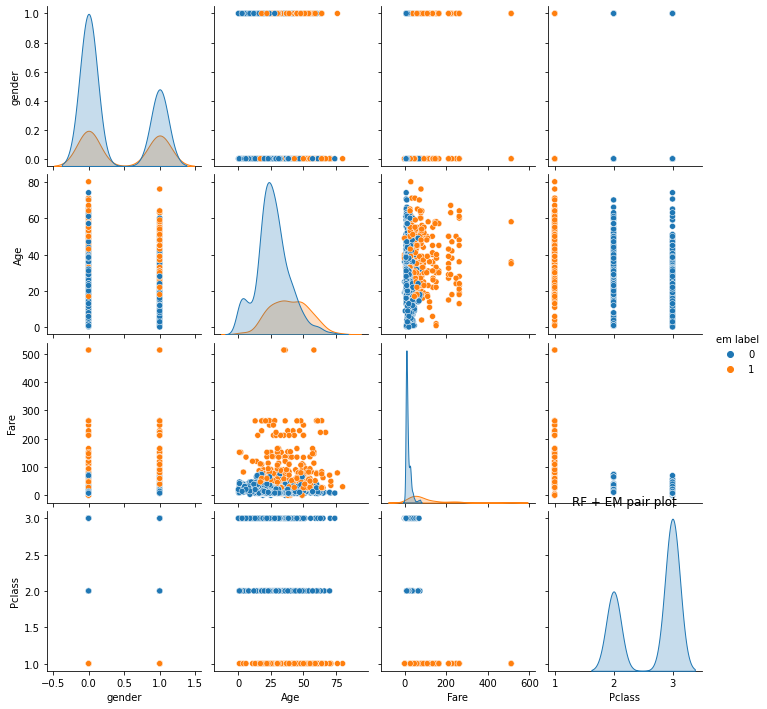

In [251]:
# scatter plot
fig=plt.figure(figsize=(12,12))
sns.pairplot(rf_cluster_t.drop(['cluster label', 'label'],axis=1), hue='em label')
plt.title('RF + EM pair plot')

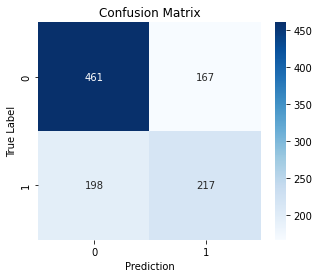

In [252]:
cf_matrix=confusion_matrix(rp_cluster_t['label'], rp_cluster_t['em label'])
plot_CFmatrix(cf_matrix)

#### Neural Nets

In [150]:
# learning curve
def learning_curve(clf, X, y):
  train_scores=[]
  val_scores=[]
  cv_scores=[]
  train_sizes=np.linspace(0.05*len(y), len(y), 20, dtype='int')

  train_times=[]
  val_times=[]

  for i in train_sizes:
    scores=cross_validate(clf, X=X.iloc[0:i,:], y=y.iloc[0:i], scoring='f1', return_train_score=True)
    #dt.fit(X_train_h.iloc[0:i,:], y_train_h.iloc[0:i])
    train_scores.append(np.mean(scores['train_score']))
    val_scores.append(np.mean(scores['test_score']))
    train_times.append(np.mean(scores['fit_time']))
    val_times.append(np.mean(scores['score_time']))

  fig1=plt.figure(figsize=(8,5))
  plt.plot(train_sizes, train_scores, marker='o', label='train')
  plt.plot(train_sizes, val_scores, marker='o', label='validation')
  plt.legend()
  plt.title('learning curve')
  plt.xlabel('training examples')
  plt.ylabel('f1 score')
  plt.show()

  # plot time
  fig2=plt.figure(figsize=(8,5))
  plt.plot(train_sizes, train_times, marker='o', label='train_time')
  plt.plot(train_sizes, val_times, marker='o', label='validation_time')
  plt.legend()
  plt.title('Modeling time')
  plt.xlabel('training examples')
  plt.ylabel('fitting time(s)')
  plt.show()
  return train_scores, val_scores, train_times, val_times

##### dimention reduced

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

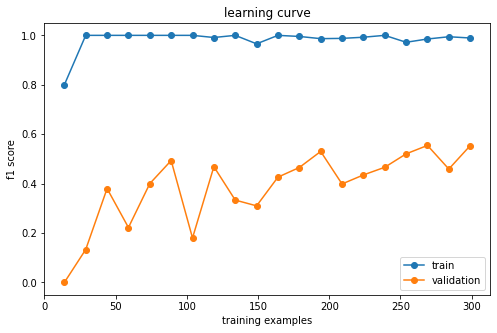

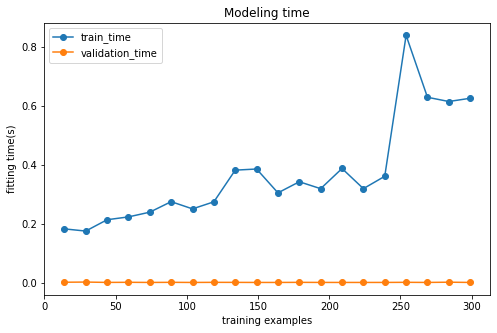

In [168]:
# train neural nets
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(scaled_health),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam', max_iter=2000)
nn_ts, nn_vs, nn_tt, nn_vt=learning_curve(nn, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
 

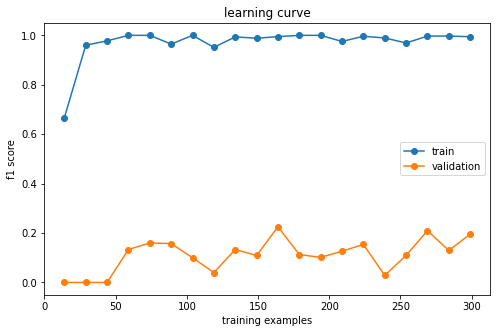

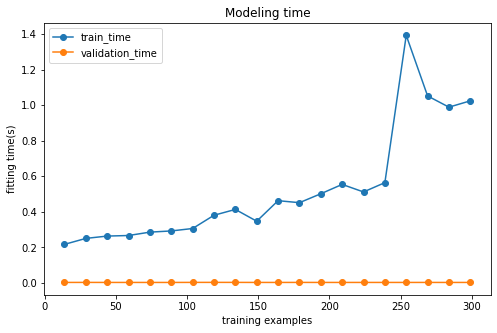

In [169]:
# train pca health
X_train_pca, X_test_pca, y_train, y_test = train_test_split(pd.DataFrame(pca_health),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_pca, nn_vs_pca, nn_tt_pca, nn_vt_pca=learning_curve(nn, X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

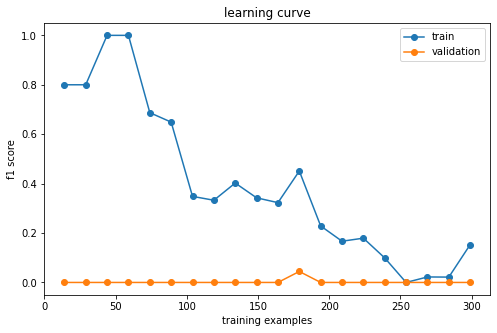

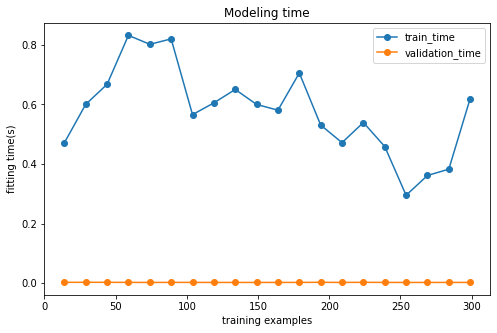

In [170]:
# train ica health
X_train_ica, X_test_ica, y_train, y_test = train_test_split(pd.DataFrame(ica_health),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_ica, nn_vs_ica, nn_tt_ica, nn_vt_ica=learning_curve(nn, X_train_ica, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

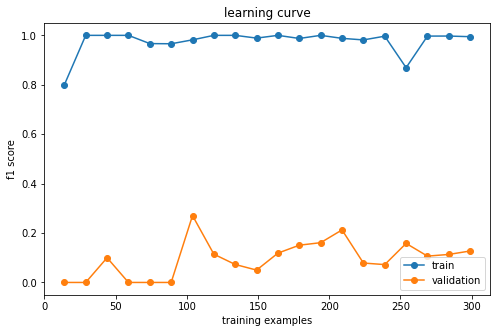

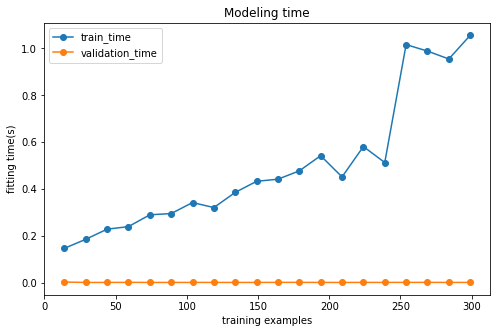

In [171]:
# train rp health
X_train_rp, X_test_rp, y_train, y_test = train_test_split(pd.DataFrame(rp_health),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rp, nn_vs_rp, nn_tt_rp, nn_vt_rp=learning_curve(nn, X_train_rp, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

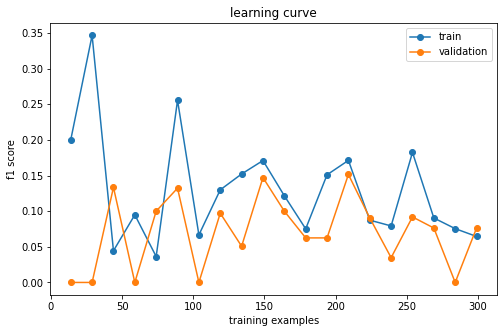

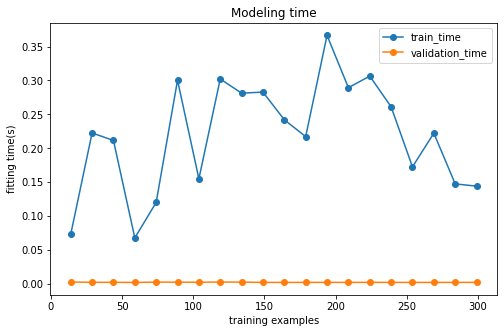

In [173]:
# train rf health
X_train_rf, X_test_rf, y_train, y_test = train_test_split(pd.DataFrame(rf_health),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rf, nn_vs_rf, nn_tt_rf, nn_vt_rf=learning_curve(nn, X_train_rf, y_train)

Text(0, 0.5, 'f1 score')

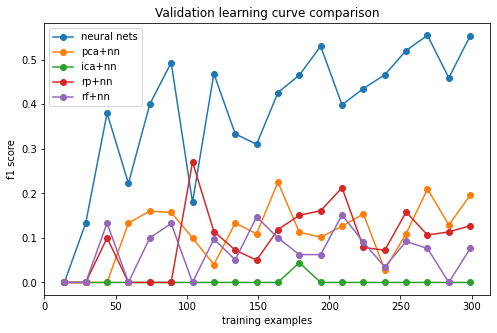

In [175]:
# plot learning curve
train_sizes=np.linspace(len(y_train)*0.05, len(y_train), 20, dtype='int')
fig=plt.figure(figsize=(8,5))
plt.plot(train_sizes, nn_vs, marker='o', label='neural nets')
plt.plot(train_sizes, nn_vs_pca, marker='o', label='pca+nn')
plt.plot(train_sizes, nn_vs_ica, marker='o', label='ica+nn')
plt.plot(train_sizes, nn_vs_rp, marker='o', label='rp+nn')
plt.plot(train_sizes, nn_vs_rf, marker='o', label='rf+nn')
plt.legend()
plt.title('Validation learning curve comparison')
plt.xlabel('training examples')
plt.ylabel('f1 score')

Text(0, 0.5, 'training time(s)')

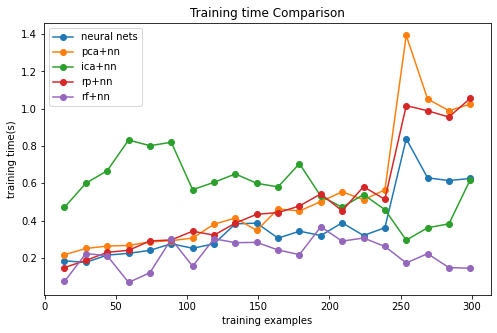

In [176]:
# plot fitting time
fig11=plt.figure(figsize=(8,5))
plt.plot(train_sizes, nn_tt, marker='o', label='neural nets')
plt.plot(train_sizes, nn_tt_pca, marker='o', label='pca+nn')
plt.plot(train_sizes, nn_tt_ica, marker='o', label='ica+nn')
plt.plot(train_sizes, nn_tt_rp, marker='o', label='rp+nn')
plt.plot(train_sizes, nn_tt_rf, marker='o', label='rf+nn')
plt.legend()
plt.title('Training time Comparison')
plt.xlabel('training examples')
plt.ylabel('training time(s)')

In [ ]:
# performance

##### dimention reduced clustering

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


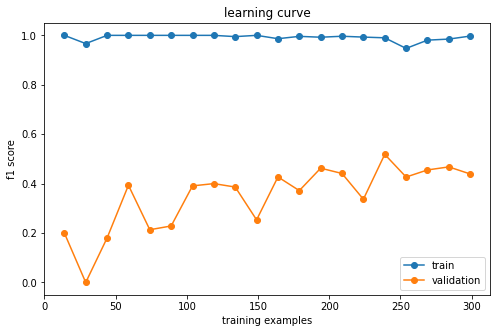

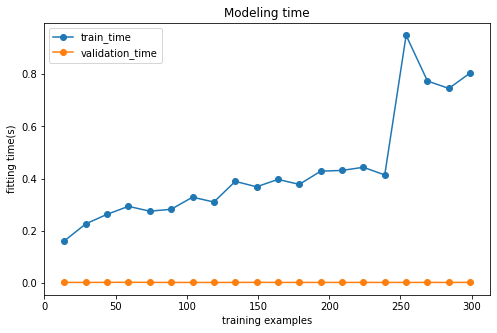

In [198]:
# train pca health + Kmeans
X_train_pcak, X_test_pcak, y_train, y_test = train_test_split(pca_cluster.drop(['label','em label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_pcak, nn_vs_pcak, nn_tt_pcak, nn_vt_pcak=learning_curve(nn, X_train_pcak, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

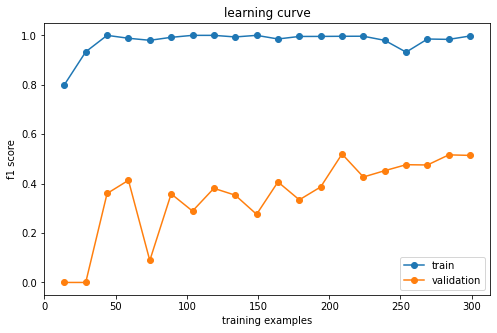

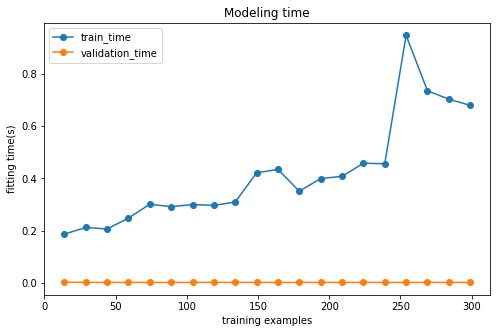

In [199]:
# train pca health + EM
X_train_pcae, X_test_pcae, y_train, y_test = train_test_split(pca_cluster.drop(['label','cluster label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_pcae, nn_vs_pcae, nn_tt_pcae, nn_vt_pcae=learning_curve(nn, X_train_pcae, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

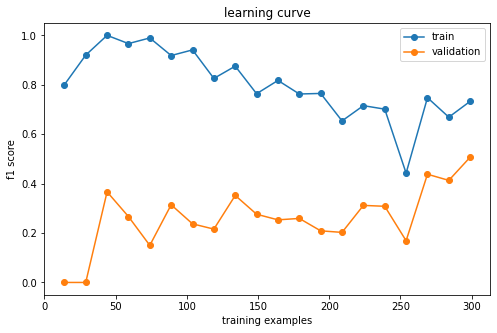

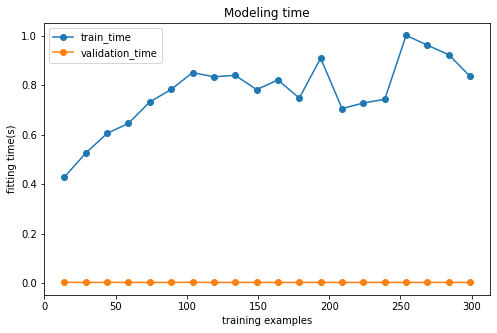

In [200]:
# train ica health + Kmeans
X_train_icak, X_test_icak, y_train, y_test = train_test_split(ica_cluster.drop(['label','em label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_icak, nn_vs_icak, nn_tt_icak, nn_vt_icak=learning_curve(nn, X_train_icak, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and t

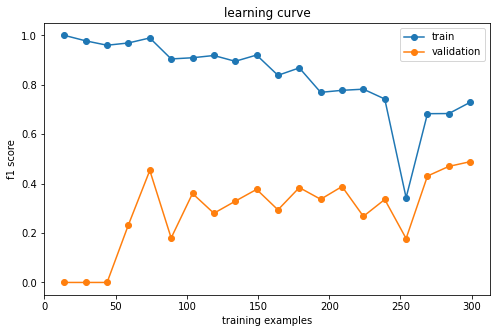

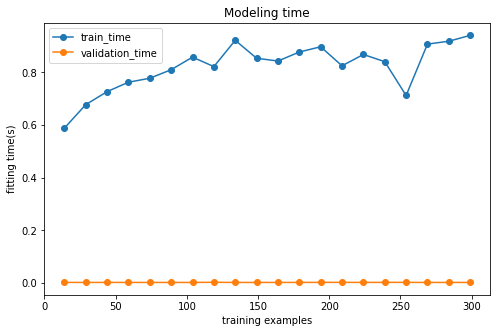

In [201]:
# train ica health + EM
X_train_icae, X_test_icae, y_train, y_test = train_test_split(ica_cluster.drop(['label','cluster label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_icae, nn_vs_icae, nn_tt_icae, nn_vt_icae=learning_curve(nn, X_train_icae, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


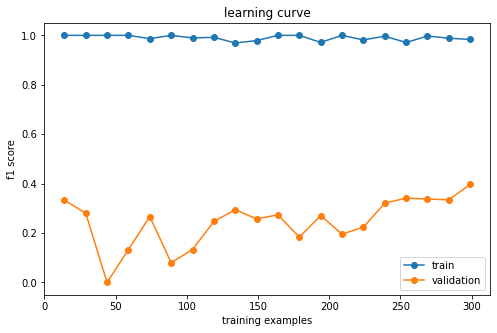

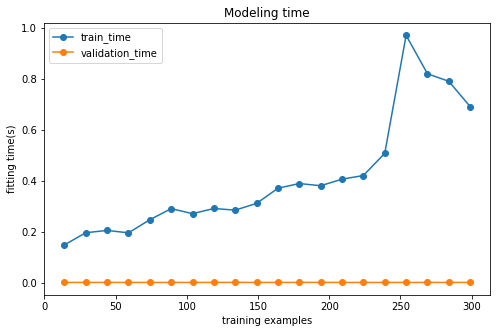

In [202]:
# train rp health + Kmeans
X_train_rpk, X_test_rpk, y_train, y_test = train_test_split(rp_cluster.drop(['label','em label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rpk, nn_vs_rpk, nn_tt_rpk, nn_vt_rpk=learning_curve(nn, X_train_rpk, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

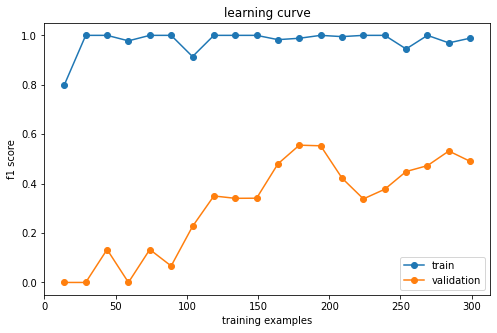

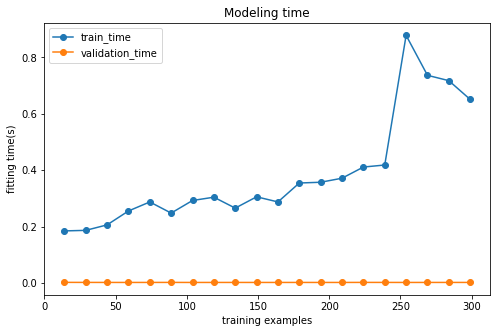

In [203]:
# train rp health + EM
X_train_rpe, X_test_rpe, y_train, y_test = train_test_split(rp_cluster.drop(['label','cluster label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rpe, nn_vs_rpe, nn_tt_rpe, nn_vt_rpe=learning_curve(nn, X_train_rpe, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predict

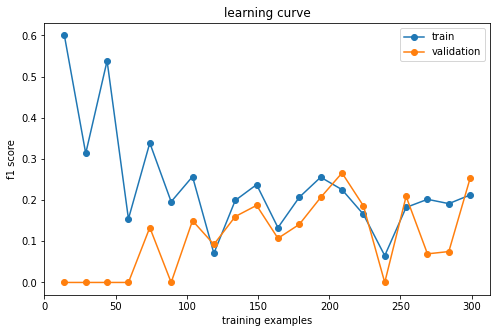

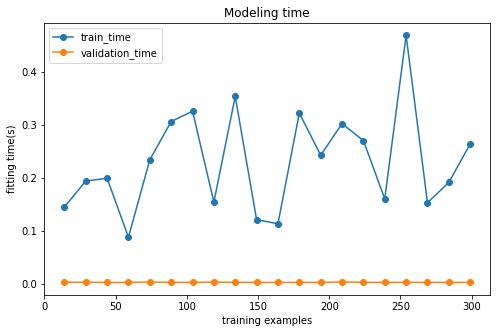

In [204]:
# train rf health + Kmeans
X_train_rfk, X_test_rfk, y_train, y_test = train_test_split(rf_cluster.drop(['label','em label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rfk, nn_vs_rfk, nn_tt_rfk, nn_vt_rfk=learning_curve(nn, X_train_rfk, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

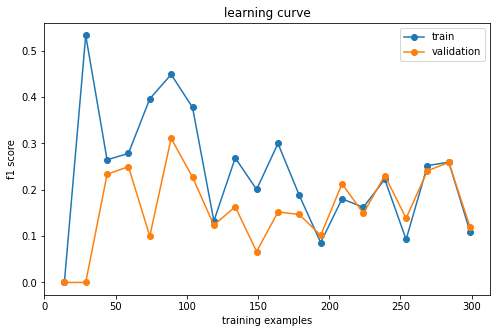

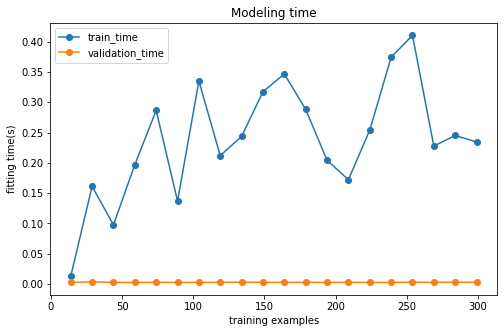

In [205]:
# train rf health + EM
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(rf_cluster.drop(['label','cluster label'],axis=1),
                                                    df_health_dn['outcome'], 
                                                    test_size=0.30)
nn=MLPClassifier(hidden_layer_sizes=(10,), solver='adam',max_iter=2000)
nn_ts_rfe, nn_vs_rfe, nn_tt_rfe, nn_vt_rfe=learning_curve(nn, X_train_rfe, y_train)

Text(0, 0.5, 'f1 score')

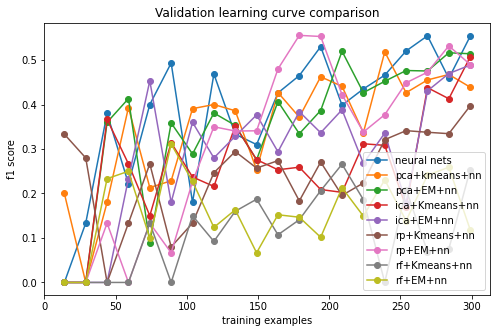

In [206]:
# performance comparison
train_sizes=np.linspace(len(y_train)*0.05, len(y_train), 20, dtype='int')
fig=plt.figure(figsize=(8,5))
plt.plot(train_sizes, nn_vs, marker='o', label='neural nets')
plt.plot(train_sizes, nn_vs_pcak, marker='o', label='pca+kmeans+nn')
plt.plot(train_sizes, nn_vs_pcae, marker='o', label='pca+EM+nn')
plt.plot(train_sizes, nn_vs_icak, marker='o', label='ica+Kmeans+nn')
plt.plot(train_sizes, nn_vs_icae, marker='o', label='ica+EM+nn')
plt.plot(train_sizes, nn_vs_rpk, marker='o', label='rp+Kmeans+nn')
plt.plot(train_sizes, nn_vs_rpe, marker='o', label='rp+EM+nn')
plt.plot(train_sizes, nn_vs_rfk, marker='o', label='rf+Kmeans+nn')
plt.plot(train_sizes, nn_vs_rfe, marker='o', label='rf+EM+nn')
plt.legend()
plt.title('Validation learning curve comparison')
plt.xlabel('training examples')
plt.ylabel('f1 score')

Text(0, 0.5, 'training time(s)')

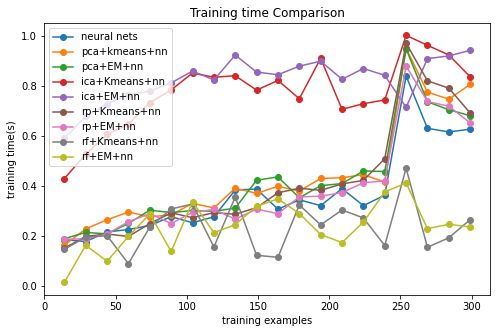

In [207]:
# training time comparison
fig=plt.figure(figsize=(8,5))
plt.plot(train_sizes, nn_tt, marker='o', label='neural nets')
plt.plot(train_sizes, nn_tt_pcak, marker='o', label='pca+kmeans+nn')
plt.plot(train_sizes, nn_tt_pcae, marker='o', label='pca+EM+nn')
plt.plot(train_sizes, nn_tt_icak, marker='o', label='ica+Kmeans+nn')
plt.plot(train_sizes, nn_tt_icae, marker='o', label='ica+EM+nn')
plt.plot(train_sizes, nn_tt_rpk, marker='o', label='rp+Kmeans+nn')
plt.plot(train_sizes, nn_tt_rpe, marker='o', label='rp+EM+nn')
plt.plot(train_sizes, nn_tt_rfk, marker='o', label='rf+Kmeans+nn')
plt.plot(train_sizes, nn_tt_rfe, marker='o', label='rf+EM+nn')
plt.legend()
plt.title('Training time Comparison')
plt.xlabel('training examples')
plt.ylabel('training time(s)')